# Query Log Analysis

The goal of this notebook is to serve as a way to quickly analyze a query log, based on the following aspects:

- Query-level
- Topic-level
- Session-level
- Term-level
- Entity-level

Our main focus is on understanding how people search, in order to improve entity-oriented search, thus we will tackle these aspects always around the entities.

**Requirements:**

- pandas
- numpy
- sklearn
- igraph
- progressbar2

**Suggestion:**

For better exploration and readability of this notebook install the extensions:
  
  - collapsible_headings
    ```sh
    pip install jupyter_contrib_nbextensions
    jupyter nbextension enable collapsible_headings/main
    ```
  - toc
    ```sh
    jupyter nbextension install --user https://rawgithub.com/minrk/ipython_extensions/master/nbextensions/toc.js
    jupyter nbextension enable toc
    ```

## Dependencies

In [1]:
import os
import re
import codecs
import collections
import warnings
import progressbar
import gzip
import datetime
import hashlib
import itertools

import urllib.parse

import igraph

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import naive_bayes, linear_model

from joblib import Memory

%load_ext autotime

## Settings

In [2]:
DEFAULT_FIGSIZE = [15, 3]
DEFAULT_MAX_ROWS = 8

plt.rc('figure', figsize=DEFAULT_FIGSIZE)
matplotlib.style.use('ggplot')
pd.set_option('display.max_rows', DEFAULT_MAX_ROWS)

memory = Memory('output/cache', verbose=0)

time: 4.46 ms


## Utilities

In [3]:
def flatten(l, remove_none=True):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        elif not el is None:
            yield el

list(flatten([1,2,[4,5], [[6,7,None]], None]))

[1, 2, 4, 5, 6, 7]

time: 20.7 ms


In [4]:
def mk_outdir(output_dir):
    path = os.path.join("output", output_dir)
    os.makedirs(path, exist_ok=True)
    return path

time: 7.46 ms


# Structure of the data directory

Before loading your data, please obtain the datasets from the corresponding sources, as listed above. The `data` directory tree should look something like this:

```bash
data/
├── ant-search-log
│   ├── ant-search_interaction_log-20190731T1621.csv.gz
│   └── ant-search_query_log-20190731T1621.csv.gz
├── AOL-user-ct-collection
│   ├── user-ct-test-collection-01.txt.gz
│   ├── user-ct-test-collection-02.txt.gz
│   ├── user-ct-test-collection-03.txt.gz
│   ├── user-ct-test-collection-04.txt.gz
│   ├── user-ct-test-collection-05.txt.gz
│   ├── user-ct-test-collection-06.txt.gz
│   ├── user-ct-test-collection-07.txt.gz
│   ├── user-ct-test-collection-08.txt.gz
│   ├── user-ct-test-collection-09.txt.gz
│   ├── user-ct-test-collection-10.txt.gz
│   └── U500k_README.txt
├── bbc
│   ├── business
│   │   ├── 001.txt
│   │   ├── 002.txt
│   │   ├── 003.txt
│   │   └── ...
│   ├── entertainment
│   │   ├── 001.txt
│   │   ├── 002.txt
│   │   ├── 003.txt
│   │   └── ...
│   ├── politics
│   │   ├── 001.txt
│   │   ├── 002.txt
│   │   ├── 003.txt
│   │   └── ...
│   ├── sport
│   │   ├── 001.txt
│   │   ├── 002.txt
│   │   ├── 003.txt
│   │   └── ...
│   ├── tech
│   │   ├── 001.txt
│   │   ├── 002.txt
│   │   ├── 003.txt
│   │   └── ...
│   └── README.TXT
├── entity_lists
│   ├── en_dbpedia_organization.txt
│   ├── en_dbpedia_person.txt
│   ├── en_dbpedia_place.txt
│   ├── pt_dbpedia_organization.txt
│   ├── pt_dbpedia_person.txt
│   └── pt_dbpedia_place.txt
├── episa -> /media/hdd0/datasets/episa
│   ├── Logs_Web1
│   │   ├── u_ex190601.log
│   │   ├── u_ex190602.log
│   │   ├── u_ex190603.log
│   │   └── ...
│   └── Logs_Web2
│       ├── u_ex19063022.log
│       ├── u_ex19063023.log
│       ├── u_ex19070100.log
│       └── ...
├── psql_stopwords
│   ├── english.stop
│   └── portuguese.stop
├── simplewiki_link_graph-201812.gml
└── webis-smc-12.txt

```

# Datasets

While we take advantage of the Wikipedia query log for this analysis, we use an intermediate structure, so that you can convert your own query log into our format and analyze it. We begin by applying the analysis to the webis-smc-12 dataset, only then adapting the notebook for the Wikipedia query log.

The loader functions will be responsible for loading query log datasets and converting them into a Pandas DataFrame with the following valid columns (only columns with data are required):

- user_id
- query
- timestamp
- click_rank
- click_title
- click_url
- click_timestamp

## webis-smc-12

The Webis Search Mission Corpus 2012 (Webis-SMC-12) contains 8840 entries for 127 users. It is built from a subset of the AOL query log. Each entry includes user ID, query, timestamp, rank and domain URL for clicked results, a mission ID and a comment. Each user is preceded by a line of dashes in the text file. More information is available at: https://webis.de/data/webis-smc-12.html

In [5]:
def load_webis_smc_12(path):
    """Load webis-smc-12.txt file into the notebook query log analysis format."""
   
    def date_parser(date_str):
        if type(date_str) is float and np.isnan(date_str):
            return np.nan
        else:
            return pd.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            
    def get_sep_row_idx():
        sep_row_idx = []
        
        with open(path, "r") as fp:
            line_number = 0
            for line in fp:
                if line.startswith("---"):
                    sep_row_idx.append(line_number)
                line_number += 1
        
        return sep_row_idx
    
    df = pd.read_csv(
        'data/webis-smc-12.txt',
        sep='\t',
        lineterminator='\n',
        skiprows=get_sep_row_idx(),
        error_bad_lines=False,
        warn_bad_lines=False,
        parse_dates=['TimeStamp'],
        date_parser=date_parser)

    df.drop(columns=['MissionID', 'Comment'], inplace=True)
    
    df.rename(
        columns={
            'UserID': 'user_id',
            'Query': 'query',
            'TimeStamp': 'timestamp',
            'ClickRank': 'click_rank',
            'ClickDomain': 'click_url'
        },
        inplace=True)
    
    df.click_rank = df.click_rank.astype(pd.Int64Dtype())
    
    return df, mk_outdir("webis-smc-12"), "en"

time: 36.7 ms


## AOL query log

AOL query log contains 36 million entries from over half a million users, covering a period of three months, from March to May 2006. The dataset itself contains 10 text files, each containing a user ID, the query, a timestamp and, if present, the rank and URL of a clicked result. While this has become a controversial dataset, because of privacy issues, it remains one of the largest available datasets for analyzing user behavior.

In [6]:
def load_aol_query_log(path):
    data = pd.DataFrame(columns=['user_id', 'query', 'timestamp', 'click_rank', 'click_url'])
    
    for filename in sorted(os.listdir(path)):
        if filename.startswith('user-ct-test-collection-'):
            df = pd.read_csv(
                    os.path.join(path, filename),
                    sep='\t',
                    parse_dates=['QueryTime'],
                    low_memory=False,
                    compression='gzip'
                ).rename(columns={
                    'AnonID': 'user_id',
                    'Query': 'query',
                    'QueryTime': 'timestamp',
                    'ItemRank': 'click_rank',
                    'ClickURL': 'click_url'
                })
            data = data.append(df, ignore_index=True)
    
    data['user_id'] = pd.to_numeric(data['user_id'], errors='coerce')
    data['click_rank'] = pd.to_numeric(data['click_rank'], errors='coerce')

    return data, mk_outdir("aol-query-log"), "en"

time: 16.1 ms


## ANT search log

The [ANT](https://ant.fe.up.pt) search log contains 45,059 search queries, mostly in Portuguese, for 9,403 users, as identified by a hash of their client IP, user agent and display resolution. It also separately provides interaction data about result clicks, containing 27480 records for 7642 users, that should match the users in the query log. The ANT search query log provides the query category according to the classification by [Pound et al. (2010)](https://doi.org/10.1145/1772690.1772769), as computed by [ANT's query understanding module](https://doi.org/10.1007/978-3-319-44564-9_17). Please notice that there is an error associated discovering a query's category, as this was not manually annotated.

In [7]:
def load_ant_search_log(path):
    q_paths = [fn for fn in os.listdir(path) if fn.startswith('ant-search_query_log-')]
    i_paths = [fn for fn in os.listdir(path) if fn.startswith('ant-search_interaction_log-')]
    
    assert len(q_paths) > 0 and len(i_paths) > 0, \
        'Both an "ant-search_query_log-*.csv.gz" and an "ant-search_interaction_log-*.csv.gz" must exist'
    
    q_path = os.path.join(path, sorted(q_paths)[-1])
    i_path = os.path.join(path, sorted(i_paths)[-1])
    
    queries = pd.read_csv(q_path, sep='\t', parse_dates=['timestamp']) \
        [['user_id', 'query', 'timestamp']] \
        .dropna(subset=['user_id', 'query'])
    
    queries['click_rank'] = np.nan
    queries['click_url'] = np.nan
    queries['click_timestamp'] = np.nan
    queries['type'] = 'query'
    
    queries = queries[['user_id', 'query', 'timestamp', 'click_rank', 'click_url', 'click_timestamp', 'type']]
    
    inter = pd.read_csv(i_path, sep='\t', parse_dates=['timestamp']) \
        [['user_id', 'query', 'timestamp', 'clicked_rank', 'clicked_url']] \
        .dropna(subset=['user_id', 'query']) \
        .rename(columns={
            'clicked_rank': 'click_rank',
            'clicked_url': 'click_url'
        })
    
    inter['click_timestamp'] = inter['timestamp']
    inter['type'] = 'click'
    
    inter = inter[['user_id', 'query', 'timestamp', 'click_rank', 'click_url', 'click_timestamp', 'type']]
    
    df = pd.concat([queries, inter]) \
        .sort_values(by='timestamp') \
        .reset_index()
            
    return df, mk_outdir("ant-search-log"), "pt"

time: 64.5 ms


## EPISA DigitArq access log

The EPISA DigitArq access log contains 110,447,807 entries. We filtered 111,819 requests to `/results` and 309,517 requests to `/details`, corresponding to result clicks.

You can generate the required `results.log` and `details.log` from the original access log files by running the following commands, after decompressing both 7-zip files:

```
(cd Logs_Web1 && awk 'BEGIN { FS=" " } $5 ~ /^\/results.*/ { print $0 }' *) | sudo tee results.log
(cd Logs_Web2 && awk 'BEGIN { FS=" " } $5 ~ /^\/results.*/ { print $0 }' *) | sudo tee -a results.log

(cd Logs_Web1 && awk 'BEGIN { FS=" " } $5 ~ /^\/details.*/ { print $0 }' *) | sudo tee details.log
(cd Logs_Web2 && awk 'BEGIN { FS=" " } $5 ~ /^\/details.*/ { print $0 }' *) | sudo tee -a details.log
```

In [8]:
# FIXME This does not yet work, as there is no relation between queries and clicked results.
def load_episa_search_log(*paths):
    base_uri = 'https://digitarq.arquivos.pt'
    bots_re = re.compile(r'.*(nagios|bot).*', re.IGNORECASE)
    query_re = re.compile(r"""^/results?.*t=([^&]+)""")

    def log_entry_generator():
        for path in paths:
            with codecs.open(path, 'r', 'utf-8') as fp:
                for line in fp:
                    yield line.strip()

    def unicode_unquote(text):
        def unicode_unquoter(match):
            return chr(int(match.group(1),16))
        return re.sub(r'%u([0-9a-fA-F]{4})', unicode_unquoter, text)

    def build_url(uri_stem, uri_query):
        if uri_query is not None and uri_query != '-':
            url = '%s?%s' % (uri_stem, uri_query)
        else:
            url = uri_stem
            
        return unicode_unquote(urllib.parse.unquote(url))
                    
    def uri_to_search_query(uri_stem, uri_query):
        url = build_url(uri_stem, uri_query)
        query_m = query_re.match(url)
        if query_m:
            return query_m.group(1)

    data = {
        'user_id': [],
        'query': [],
        'timestamp': [],
        'click_rank': [],
        'click_url': [],
        'referer': []
    }
    
    for line in log_entry_generator():
        if line.startswith('#'):
            continue
        
        date, time, _, _, uri_stem, uri_query, _, _, client_ip, client_ua, referer, _  = line.split(maxsplit=11)
        
        if bots_re.match(client_ua):
            #warnings.warn('Skipping bot: %s' % client_ua)
            continue
            
        if uri_stem.startswith('/details') and not referer.startswith('https://digitarq.arquivos.pt/results'):
            #warnings.warn('Skipping details without referer: %s' % uri_stem)
            continue
            
        user_id = hashlib.md5(('%s %s' % (client_ip, client_ua)).encode()).hexdigest()
        
        query = uri_to_search_query(uri_stem, uri_query)
        
        timestamp = pd.to_datetime('%s %s' % (date, time))
        
        click_rank = None
        
        if uri_stem.startswith('/details'):
            click_url = urllib.parse.urljoin(base_uri, build_url(uri_stem, uri_query))
        else:
            click_url = None
        
        referer = None if referer == '-' else referer
        
        if query is None and click_url is None:
            continue
        
        data['user_id'].append(user_id)
        data['query'].append(query)
        data['timestamp'].append(timestamp)
        data['click_rank'].append(None)
        data['click_url'].append(click_url)       
        data['referer'].append(referer)
        
    df = pd.DataFrame(data) \
        .sort_values(by=['user_id', 'timestamp'])
    
    return df, mk_outdir("episa-digitarq-access-log"), "pt"

time: 183 ms


# Data loading

Select one of the available dataset loading functions to begin the analysis:

- load_webis_smc_12
- load_aol_query_log
- load_ant_search_log
- load_episa_search_log

In [9]:
#qlog, output_dir, lang = load_webis_smc_12('data/webis-smc-12.txt')
#qlog, output_dir, lang = load_aol_query_log('data/AOL-user-ct-collection')
qlog, output_dir, lang = load_ant_search_log('data/ant-search-log')
#qlog, output_dir, lang = load_episa_search_log('data/episa/results.log', 'data/episa/details.log')

display(output_dir)
display(qlog)

'output/ant-search-log'

,index,user_id,query,timestamp,click_rank,click_url,click_timestamp,type
0,0,475b4acbeea5b8590c1818af7bd4ce61,josé devezas,2015-12-01 15:55:11.872807,3.0,NaN,2015-12-01 15:55:11.872807,click
1,1,475b4acbeea5b8590c1818af7bd4ce61,noémia moreira,2015-12-01 15:59:48.279617,1.0,NaN,2015-12-01 15:59:48.279617,click
2,2,475b4acbeea5b8590c1818af7bd4ce61,noémia moreira,2015-12-01 15:59:52.694495,1.0,http://sigarra.up.pt/feup/pt/vld_entidades_ger...,2015-12-01 15:59:52.694495,click
3,3,475b4acbeea5b8590c1818af7bd4ce61,josé devezas ricardo amorim i123 funcionário,2015-12-01 16:01:39.609899,1.0,NaN,2015-12-01 16:01:39.609899,click
...,...,...,...,...,...,...,...,...
70174,45064,b1a54f7f12ea62fe3e0564c35b67aab4,pré graduação,2019-07-31 16:04:22.206000,NaN,NaN,NaT,query
70175,45065,4ac8b6d9bd0a88346c0beb040e66a38a,"""Pedro Amorim Brandão da Silva""",2019-07-31 16:12:00.835000,NaN,NaN,NaT,query
70176,45066,0f64acb721d055e2ad87e4d24c183a83,"""José Ferreira Alves""",2019-07-31 16:12:54.958000,NaN,NaN,NaT,query
70177,45067,1a20834ce8f2b27145babeba6f450ead,tesouraria,2019-07-31 16:16:39.872000,NaN,NaN,NaT,query


time: 362 ms


# Query-level analysis

- Number of queries / interactions
- Number of distinct queries
- Distribution of number of queries / interactions per user
- Distribution of queries / interactions over time
  - Per day
  - For 24h cycles
  - For weekday cycles
  - For monthly cycles

## Total number of queries and distinct queries

In [232]:
qlevel_stats = pd.DataFrame(
    [qlog.shape[0], qlog['query'].nunique(), qlog['user_id'].nunique()],
    columns=['value'],
    index=['num_queries', 'num_distinct_queries', 'num_users'])
qlevel_stats

,value
num_queries,70178
num_distinct_queries,17002
num_users,13254


time: 38 ms


## Distribution of number of queries per user

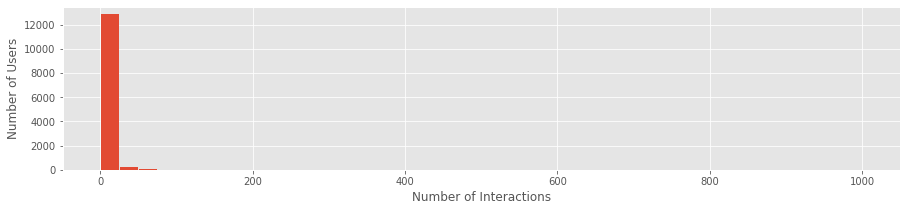

time: 381 ms


In [11]:
queries_per_user = qlog[['user_id', 'query']] \
    .groupby(['user_id']) \
    .count()

d_max = queries_per_user['query'].max()
bin_width = 25

queries_per_user \
    .plot(kind='hist', bins=range(0, d_max+bin_width, bin_width), logy=False, rwidth=.95, legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()

## Distribution of queries over time

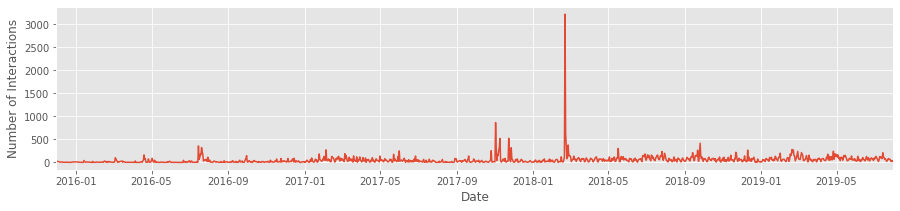

time: 398 ms


In [12]:
qlog['date'] = qlog['timestamp'].map(lambda t: t.date())

qlog \
    .groupby('date') \
    .size() \
    .plot()
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

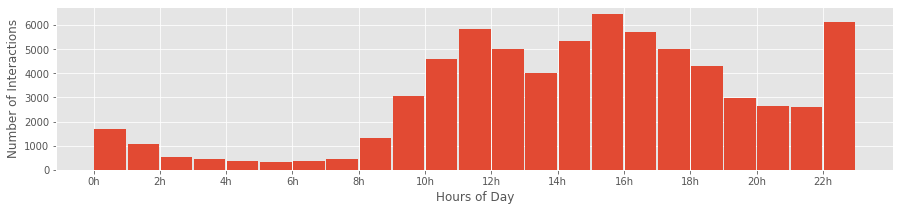

time: 435 ms


In [13]:
qlog['hour'] = qlog['timestamp'].map(lambda t: t.hour)
qlog['hour'] \
    .plot(kind='hist', bins=23, rwidth=.95)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)])
plt.xlabel('Hours of Day')
plt.ylabel('Number of Interactions')
plt.show()

### Per weekday cycles

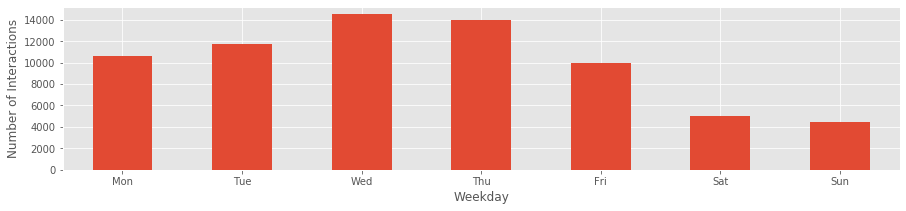

time: 387 ms


In [14]:
weekdays=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
qlog['weekday'] = qlog['timestamp'].map(lambda t: t.weekday())

qlog \
    .groupby(['weekday']) \
    .size() \
    .plot(kind='bar')

plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.xlabel('Weekday')
plt.ylabel('Number of Interactions')
plt.show()

### Per monthly cycles

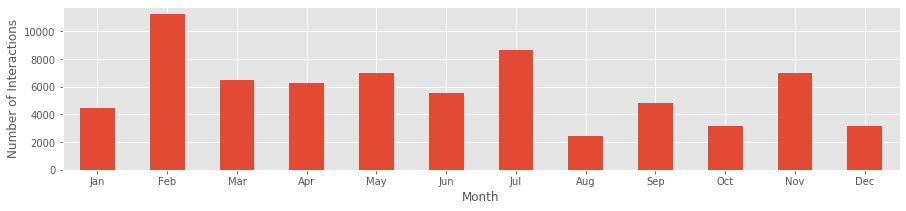

time: 417 ms


In [15]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
qlog['month'] = qlog['timestamp'].map(lambda t: t.month)

queries_per_month = qlog \
    .groupby(['month']) \
    .size() \

queries_per_month \
    .plot(kind='bar')

plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.xlabel('Month')
plt.ylabel('Number of Interactions')
plt.show()

# Topic-level analysis

We will look at the categories (more general) and topics (more specific) of the query log, analyzing:

- Distribution of query categories
- Distribution of query topics


- Distribution of query categories over time:
  - Per 24h cycles
  - Per weekday cycles
  - Per monthly cycles


- Distribution of query topics over time:
  - Per 24h cycles
  - Per weekday cycles
  - Per monthly cycles

## Category detection

We train a classifier based on the [BBC dataset](http://mlg.ucd.ie/datasets/bbc.html), with 2225 documents and 5 categories:

- business
- entertainment
- politics
- sport
- tech

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_paths_per_class(bbc_base_dir):
    """Get dictionary of paths per class for BBC dataset."""
    
    bbc = {}
    
    for file in os.listdir(bbc_base_dir):
        class_path = os.path.join(bbc_base_dir, file)
        
        if os.path.isdir(class_path):
            label = file
            bbc[label] = []
            
            for file in os.listdir(class_path):
                doc_path = os.path.join(class_path, file)
                if os.path.isfile(doc_path):
                    bbc[label].append(doc_path)
    
    return bbc


def build_training_set(paths_per_class):
    """Load text documents per class and extract features (TF-IDF per term)."""

    vec = TfidfVectorizer(ngram_range=(1, 2))
    corpus = []
    y = []
    
    for label in paths_per_class.keys():
        for path in paths_per_class[label]:
            try:
                corpus.append(codecs.open(path, 'r', 'utf-8').read())
                y.append(label)
            except:
                warnings.warn("Skipped %s" % (path))
        
    X = vec.fit_transform(corpus)
    return X, y, vec


def train(X, y):
    """
    Train a black box classifier. We chose Naïve Bayes here for returning a probability and having good proven
    performance on this dataset, as shown in: https://towardsdatascience.com/text-classification-in-python-dd95d264c802
    """
    nb = naive_bayes.MultinomialNB()
    nb.fit(X, y)
    return nb
    #lg = linear_model.LogisticRegression(class_weight='balanced')
    #lg.fit(X, y)
    #return lg


def predict(models, features_model, docs, threshold=0.5):
    """
    Predict the correct class according to the probability. If no probability is above the threshold, then the class
    'unknown' is assigned instead.
    """
    predictions = []
    
    for label, model in models.items():
        predictions.append([label] + [p[0] for p in model.predict_proba(features_model.transform(docs))])
    
    cl_prob_per_doc = pd.DataFrame(predictions) \
        .rename({ 0: 'class', 1: 0, 2: 1 }, axis=1) \
        .set_index('class')
    
    cl_prob_per_doc.loc['unknown', :] = cl_prob_per_doc.max().lt(threshold).map(int)
    
    return cl_prob_per_doc.idxmax().tolist()


def select_training_set_for_class(X, y, label):
    """Deal with class imbalance problem by using stratified bootstrapping."""
    cl_idx = {}
    unique_y = np.unique(y)
    
    for u_cl in unique_y:
        if not u_cl in cl_idx:
            cl_idx[u_cl] = []
        cl_idx[u_cl].extend(idx for idx, cl in enumerate(y) if cl == u_cl)
   
    idx = cl_idx[label]
    n_samples = int(np.ceil( len(idx) / (len(unique_y) - 1) ))
    
    for cl in unique_y:
        idx.extend(np.random.choice(cl_idx[cl], n_samples, replace=True))
    
    return idx

time: 184 ms


In [17]:
paths_per_class = get_paths_per_class('data/bbc')
X, y, features_model = build_training_set(paths_per_class)

models = {}
for label in paths_per_class.keys():
    train_idx = select_training_set_for_class(X, y, label)
    models[label] = train(X[train_idx, :], [y[i] if y[i] == label else 'unknown' for i in train_idx])

/home/jldevezas/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Skipped data/bbc/sport/199.txt


time: 3.21 s


Let's see if it works on the following test queries:

In [18]:
docs = ["government law", "soccer goal", "finance department", "computer science", "grammy award"]
predict(models, features_model, docs)

['politics', 'sport', 'business', 'tech', 'entertainment']

time: 38.2 ms


In [19]:
null_query_idx = set(qlog[qlog['query'].isnull()].index)
batch_size = 100000

for start in progressbar.progressbar(range(0, len(qlog), batch_size)):
    end = np.min([len(qlog), start+batch_size])
    batch_idx = list(set(range(start, end)).difference(null_query_idx))
    qlog.loc[batch_idx, 'category'] = predict(models, features_model, qlog.loc[batch_idx, 'query'])

100% (1 of 1) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07


time: 7.15 s


In [20]:
qlog[['query', 'category']]

,query,category
0,josé devezas,business
1,noémia moreira,business
2,noémia moreira,business
3,josé devezas ricardo amorim i123 funcionário,business
...,...,...
70174,pré graduação,business
70175,"""Pedro Amorim Brandão da Silva""",business
70176,"""José Ferreira Alves""",sport
70177,tesouraria,business


time: 23.6 ms


Let's also inspect some random rows to see if it makes sense.

In [21]:
qlog[['query', 'category']].iloc[np.random.choice(len(qlog), 10)]

,query,category
35862,score = 0.003,sport
23307,sandro,business
21871,devezas,business
10985,departamento de engenharia informática,entertainment
...,...,...
39188,bolsa de emprego,entertainment
11773,estudante química informática,business
67275,"""Arquivos e Bibliotecas Digitais""",business
31607,josé devezas,business


time: 13.9 ms


Some queries were wrongly categorized, since the training set doesn't cover all categories and the classifier we used never returns a probability under 0.5 for all of the labels. This means it's unable to use the `unknown` category.

## Topic detection

Another approach is to instead use an unsupervised algorithm. Classical topic models like LDA would be adequate, if it weren't for the short length of the queries. There is, however, the [biterm topic model](https://dl.acm.org/citation.cfm?id=2488514), which is more adequate for shorter text. Another, even better, approach could be the [relational biterm topic model](https://academic.oup.com/comjnl/article-abstract/62/3/359/5005494?redirectedFrom=fulltext), but since we didn't find any implementation and don't want to implement it ourselves, we will experiment with the biterm topic model.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms
from biterm.cbtm import oBTM

stopwords_per_lang = {
    'en': 'data/psql_stopwords/english.stop',
    'pt': 'data/psql_stopwords/portuguese.stop'
}
stopwords_per_lang = {
    lang: set(open(fn).read().splitlines())
    for lang, fn in stopwords_per_lang.items()
}

vec = CountVectorizer(stop_words=stopwords_per_lang[lang])
X = vec.fit_transform(qlog['query']).toarray()

vocab = np.array(vec.get_feature_names())
biterms = vec_to_biterms(X)

time: 4.45 s


**Note:** The following code will take a while to run. It's a lot slower than training and predicting with Naïve Bayes. We cache the model, so that we can rerun the whole notebook. Delete `output/cache` to retrain with the same data, otherwise it's fine to leave the cache untouched. The same goes for any other function annotated with `memory.cache`.

In [23]:
num_topics = 20

@memory.cache
def biterm_train(num_topics, vocabulary, biterms, iterations=100):
    btm = oBTM(num_topics=num_topics, V=vocab)
    topics = btm.fit_transform(biterms, iterations=iterations)
    return btm, topics

btm, topics = biterm_train(num_topics, vocab, biterms, iterations=100)

time: 19.9 s


We now take the topic distribution over the vocabulary and keep the top five terms, with highest probability, per topic.

In [24]:
topic_names = []
for i in range(20):
    idx = btm.phi_wz[:, i].argsort()[::-1][:5]
    topic_names.append(' '.join(vocab[i] for i in idx))

qlog['topic'] = [topic_names[topics[i].argmax()] for i in range(len(qlog))]; qlog[['query', 'topic']]

,query,topic
0,josé devezas,devezas funcionário josé nunes sérgio
1,noémia moreira,moreira noémia saúde gestão ciências
2,noémia moreira,moreira noémia saúde gestão ciências
3,josé devezas ricardo amorim i123 funcionário,devezas funcionário josé nunes sérgio
...,...,...
70174,pré graduação,23 maiores curso doutoral programa
70175,"""Pedro Amorim Brandão da Silva""",maria silva pedro ferreira santos
70176,"""José Ferreira Alves""",miguel silva josé pereira costa
70177,tesouraria,informática estudante química departamento eng...


time: 86.1 ms


## Distribution of query categories

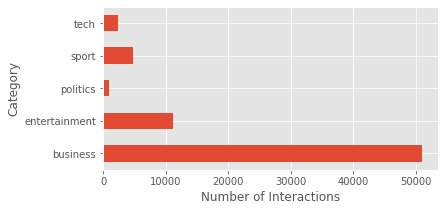

time: 162 ms


In [25]:
plt.rc('figure', figsize=[6, 3])

qlog[['query', 'category']] \
    .groupby('category') \
    .count() \
    .plot(kind='barh', legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Category')
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Distribution of query topics

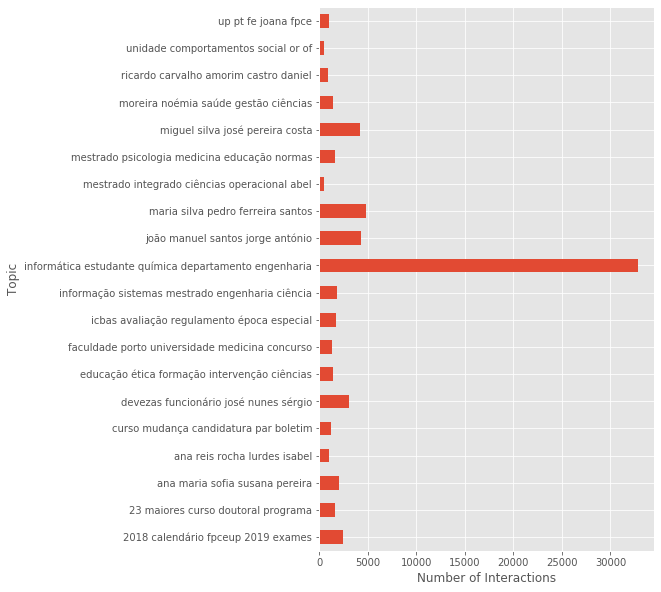

time: 357 ms


In [26]:
plt.rc('figure', figsize=[6, 10])

qlog[['query', 'topic']] \
    .groupby('topic') \
    .count() \
    .plot(kind='barh', legend=False)
plt.xlabel('Number of Interactions')
plt.ylabel('Topic')
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Distribution of query categories over time

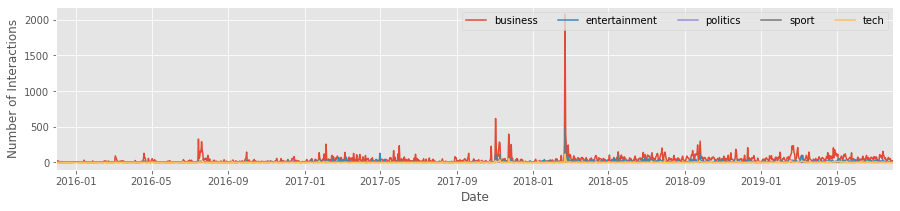

time: 348 ms


In [27]:
categories_over_time = qlog[['query', 'category', 'date']] \
    .groupby(['category', 'date']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('date') \
    .drop('level_0', axis=1) \
    .fillna(0)

categories_over_time.plot()
plt.legend(loc='upper right', ncol=5)
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

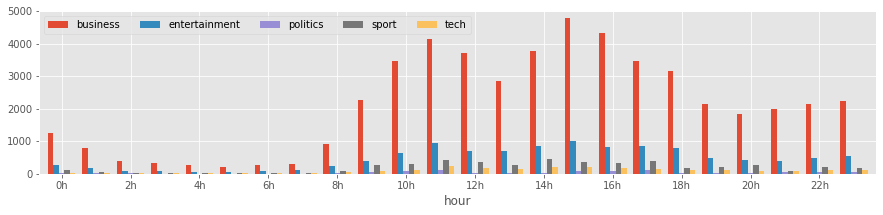

time: 428 ms


In [28]:
qlog[['query', 'category', 'hour']] \
    .groupby(['category', 'hour']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('hour') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=6)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.show()

### Per weekday cycles

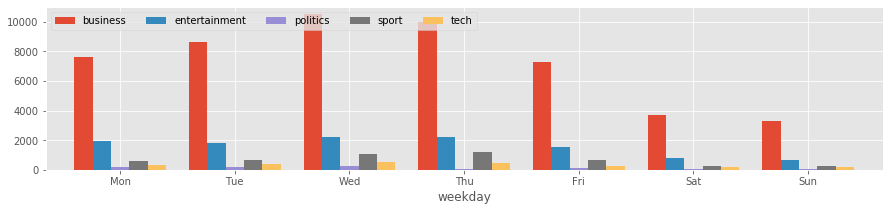

time: 268 ms


In [29]:
qlog[['query', 'category', 'weekday']] \
    .groupby(['category', 'weekday']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('weekday') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=6)
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.show()

### Per monthly cycles

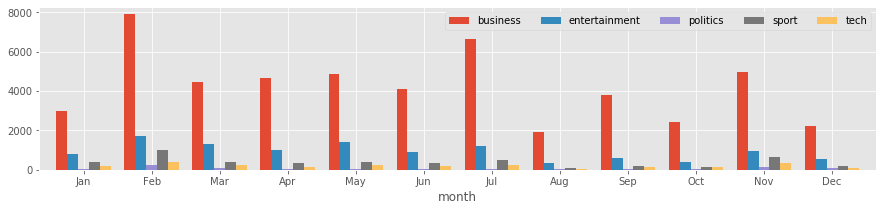

time: 369 ms


In [30]:
qlog[['query', 'category', 'month']] \
    .groupby(['category', 'month']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('month') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper right', ncol=6)
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.show()

## Distribution of query topics over time for top-4 topics

In [31]:
top_topics = qlog[['query', 'topic']] \
    .groupby('topic') \
    .count() \
    .sort_values(by="query", ascending=False) \
    .rename({'query': 'count'}, axis=1) \
    .head(4)

time: 18 ms


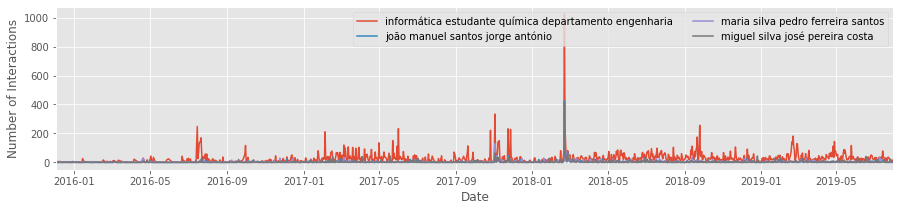

time: 358 ms


In [32]:
topics_over_time = qlog[['query', 'topic', 'date']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'date']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('date') \
    .drop('level_0', axis=1) \
    .fillna(0)

topics_over_time.plot()
plt.legend(loc='upper right', ncol=2)
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.show()

### Per 24h cycles

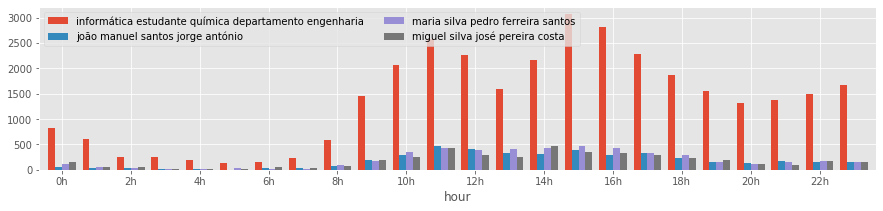

time: 399 ms


In [33]:
qlog[['topic', 'hour']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'hour']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('hour') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=2)
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.show()

### Per weekday cycles

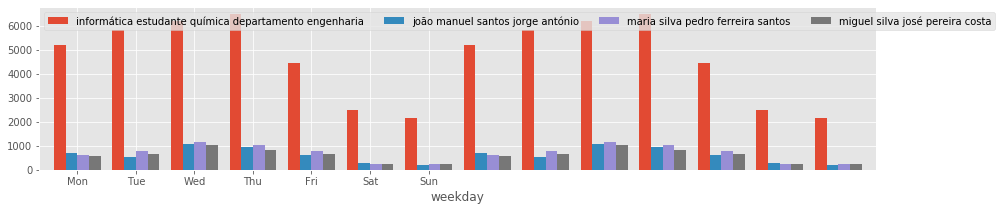

time: 321 ms


In [34]:
qlog[['query', 'topic', 'weekday']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'weekday']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('weekday') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper left', ncol=4)
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.show()

### Per monthly cycles

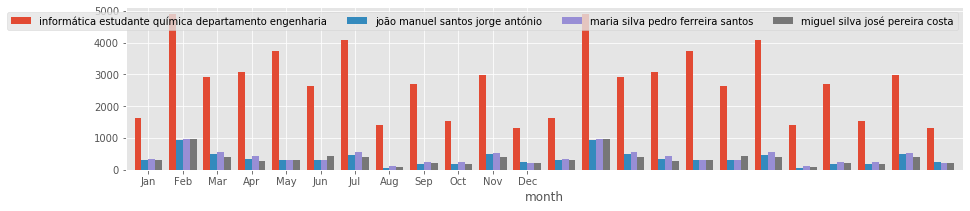

time: 412 ms


In [35]:
qlog[['query', 'topic', 'month']] \
    .merge(top_topics, on='topic') \
    .groupby(['topic', 'month']) \
    .count() \
    .unstack() \
    .T \
    .reset_index() \
    .set_index('month') \
    .drop('level_0', axis=1) \
    .plot(kind='bar', width=.8)

plt.legend(loc='upper right', ncol=4)
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.show()

# Session-level analysis

- Number of queries / interactions per session
- Number of distinct queries per session
- Session duration distribution
- Distribution of number of clicks per session
- Average clicked rank per session duration


- Average session duration:
  - Per day
  - For 24h cycles
  - For weekday cycles
  - For monthly cycles

## Detecting sessions

**Note:** Don't run the following code block if there is already a `session_id` column.

In [36]:
from datetime import timedelta

def detect_sessions(qlog, mins=30):
    qlog.drop('session_id', axis=1, errors='ignore', inplace=True)
    new_sessions = pd.Series([], dtype='int64')
    for _, user_qlog in qlog.sort_values(by=['user_id', 'timestamp']).groupby('user_id'):
        user_new_sessions = user_qlog.timestamp.gt(user_qlog.timestamp.shift() + timedelta(minutes=mins))
        user_new_sessions.iloc[0] = True
        new_sessions = new_sessions.append(user_new_sessions)
    return pd.concat([
        qlog.sort_values(by=['user_id', 'timestamp']),
        pd.DataFrame({ 'session_id': new_sessions.cumsum() })
    ], axis=1, sort=False)

qlog = detect_sessions(qlog); qlog[['user_id', 'query', 'timestamp', 'session_id']]

,user_id,query,timestamp,session_id
64767,0003984c5ce5e789c92f733b5c2727ae,Nuno Duarte Ribeiro da Silva Fonseca Oliveira,2019-05-16 12:29:16.826,1
38025,0006e9e119778b84f397655e2bf26382,i123,2018-06-22 14:11:06.350,2
58511,00081ee4834fbf52e2fa52a5686c169c,validação de diploma,2019-03-06 13:20:22.946,3
58512,00081ee4834fbf52e2fa52a5686c169c,recinhecimento de diploma,2019-03-06 13:20:49.122,3
...,...,...,...,...
64635,ffee9b7ce28d4b5f8b89f45320ecc17d,Exames,2019-05-15 15:45:24.042,19115
64636,ffee9b7ce28d4b5f8b89f45320ecc17d,Exames,2019-05-15 15:45:28.458,19115
55329,fff2c8a92fafcef6e233c8811dffa129,CANDIDATURA,2019-02-07 13:33:43.820,19116
38971,fff6f4e5e0511d593a79b676c65d5a6d,Caroline barbosa,2018-07-02 01:08:28.150,19117


time: 25 s


## Number of interactions per session

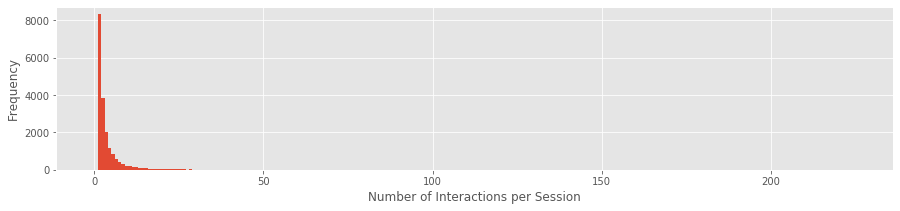

time: 544 ms


In [37]:
queries_per_session = qlog[['session_id', 'query']] \
    .groupby('session_id') \
    .count()

d_max = queries_per_session['query'].max()
bin_width = 1

queries_per_session \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), legend=False)
plt.xlabel("Number of Interactions per Session")
plt.ylabel("Frequency")
plt.show()

## Number of distinct queries per session

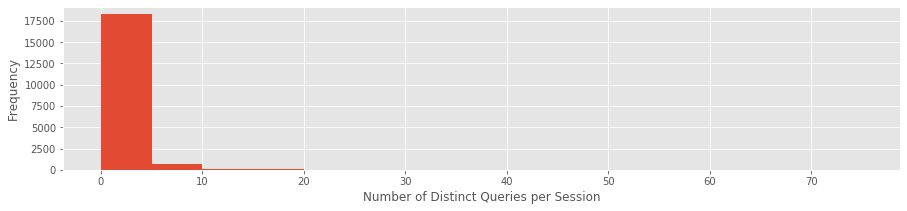

time: 310 ms


In [38]:
distinct_queries_per_session = qlog[['session_id', 'query']] \
    .groupby('session_id') \
    .nunique()

distinct_queries_per_session['session_id'] = distinct_queries_per_session.index
distinct_queries_per_session.drop('session_id', axis=1, inplace=True)
distinct_queries_per_session = distinct_queries_per_session.reset_index().drop('session_id', axis=1)

d_max = distinct_queries_per_session['query'].max()
bin_width = 5

distinct_queries_per_session \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), legend=False)
plt.xlabel("Number of Distinct Queries per Session")
plt.ylabel("Frequency")
plt.show()

## Session duration distribution

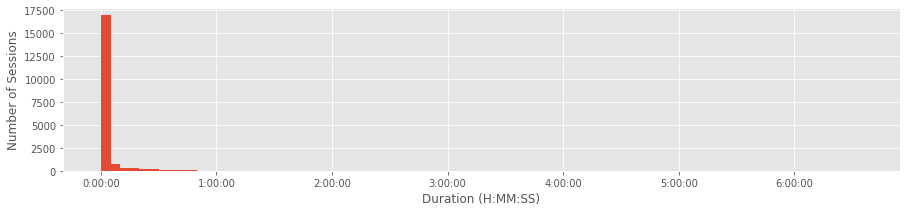

time: 7.5 s


In [39]:
from matplotlib.ticker import FuncFormatter

session_durations = qlog[['session_id', 'timestamp']] \
    .groupby('session_id') \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1)

d_max = session_durations['duration'].max()
bin_width = 5/60

ax = session_durations \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width), legend=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: timedelta(seconds=x * 3600)))
plt.xlabel("Duration (H:MM:SS)")
plt.ylabel("Number of Sessions")
plt.show()

## Distribution of number of clicks per session

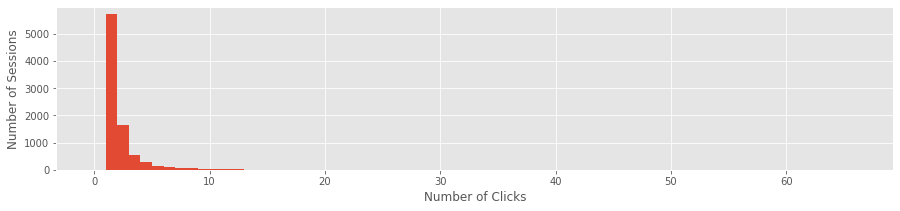

time: 335 ms


In [40]:
session_clicks = qlog[~qlog['click_rank'].isnull()][['session_id', 'click_rank']] \
    .groupby('session_id') \
    .count() \
    .reset_index() \
    .drop('session_id', axis=1) \
    .rename({ 'click_rank': 'click_count' }, axis=1)

d_max = session_clicks['click_count'].max()
bin_width = 1

session_clicks \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), logy=False, legend=False)
plt.xlabel("Number of Clicks")
plt.ylabel("Number of Sessions")
plt.show()

## Average session duration

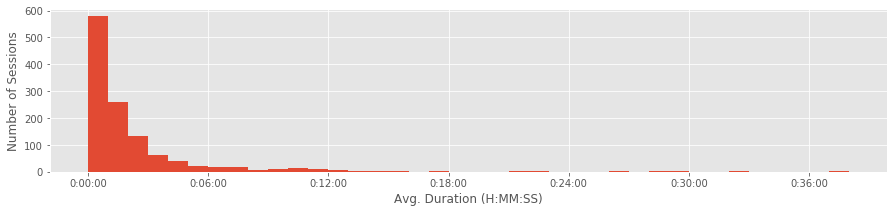

time: 7.14 s


In [41]:
from matplotlib.ticker import FuncFormatter

session_durations_per_day = qlog[['session_id', 'date', 'timestamp']] \
    .groupby(['session_id', 'date']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('date') \
    .mean()

d_max = session_durations_per_day['duration'].max()
bin_width = 1/60

ax = session_durations_per_day \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width), legend=False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=hour * 3600)))
plt.xlabel("Avg. Duration (H:MM:SS)")
plt.ylabel("Number of Sessions")
plt.show()

### Per 24h cycles

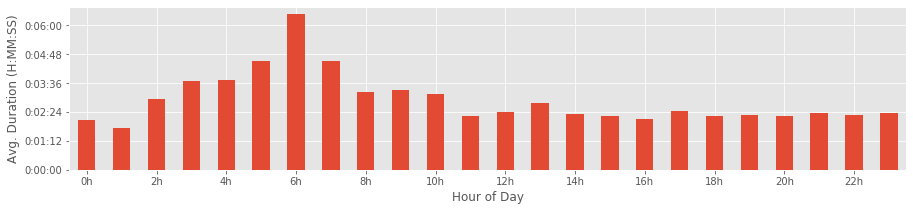

time: 7.51 s


In [42]:
from matplotlib.ticker import FuncFormatter

session_durations_per_hour_of_day = qlog[['session_id', 'hour', 'timestamp']] \
    .groupby(['session_id', 'hour']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('hour') \
    .mean()

ax = session_durations_per_hour_of_day \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(range(0, 24, 2), labels=['{0}h'.format(h) for h in range(0, 24, 2)], rotation=0)
plt.xlabel("Hour of Day")
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

### Per weekday cycles

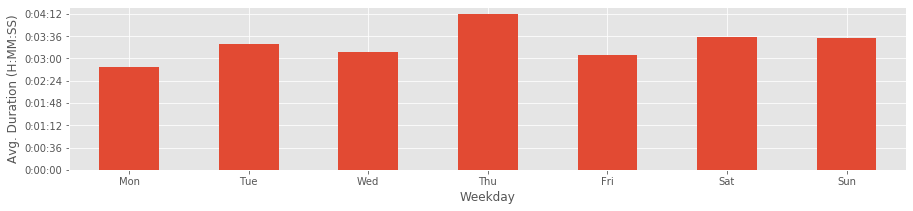

time: 7.07 s


In [43]:
from matplotlib.ticker import FuncFormatter

session_durations_per_weekday = qlog[['session_id', 'weekday', 'timestamp']] \
    .groupby(['session_id', 'weekday']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('weekday') \
    .mean()

ax = session_durations_per_weekday \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(range(len(weekdays)), labels=weekdays, rotation=0)
plt.xlabel("Weekday")
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

### Per monthly cycles

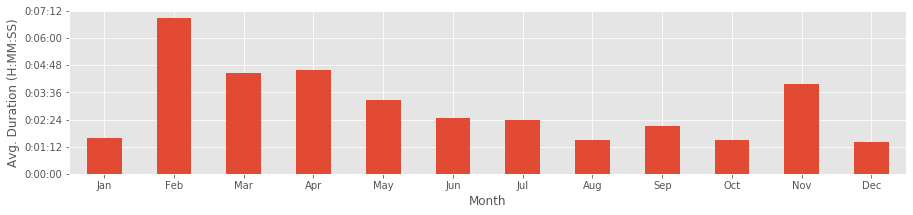

time: 7.15 s


In [44]:
from matplotlib.ticker import FuncFormatter

session_durations_per_month = qlog[['session_id', 'month', 'timestamp']] \
    .groupby(['session_id', 'month']) \
    .apply(lambda d: (d['timestamp'].max() - d['timestamp'].min()).total_seconds() / 3600) \
    .reset_index() \
    .rename({0: 'duration'}, axis=1) \
    .drop('session_id', axis=1) \
    .groupby('month') \
    .mean()

ax = session_durations_per_month \
    .plot(kind='bar', legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda hour, _: timedelta(seconds=int(hour * 3600))))
plt.xticks(
    range(queries_per_month.shape[0]),
    labels=months[(min(queries_per_month.index)-1):max(queries_per_month.index)],
    rotation=0)
plt.xlabel('Month')
plt.ylabel("Avg. Duration (H:MM:SS)")
plt.show()

## Average clicked rank per session duration

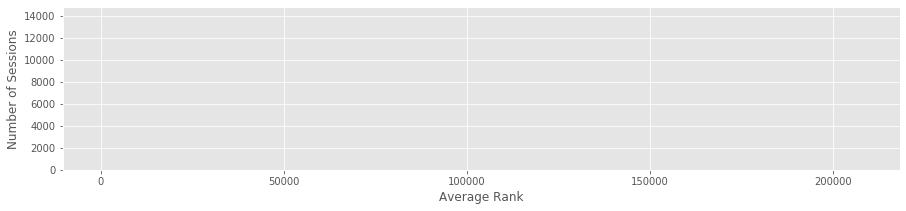

time: 6min 10s


In [45]:
session_avg_rank = qlog[['session_id', 'click_rank']] \
    .fillna(0) \
    .groupby('session_id') \
    .mean() \
    .reset_index() \
    .drop('session_id', axis=1) \
    .rename({ 'click_rank': 'avg_rank' }, axis=1)

d_max = int(np.ceil(session_avg_rank['avg_rank'].max()))
bin_width = 1

session_avg_rank \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width), logy=False, legend=False)
plt.xlabel("Average Rank")
plt.ylabel("Number of Sessions")
plt.show()

# Term-level analysis

The term-level analysis is concerned with the characteristics of the words that form the queries. Our analysis includes:

- Distribution of number of characters per query
- Distribution of number of terms per query
- Distribution of average number of terms over time
- Term popularity over time for top terms

## Distribution of number of characters per query

In [46]:
qlog['length'] = qlog['query'].map(len); qlog[['query', 'length']]

,query,length
64767,Nuno Duarte Ribeiro da Silva Fonseca Oliveira,45
38025,i123,4
58511,validação de diploma,21
58512,recinhecimento de diploma,25
...,...,...
64635,Exames,6
64636,Exames,6
55329,CANDIDATURA,11
38971,Caroline barbosa,16


time: 29.9 ms


In [47]:
qlog['length'].describe()

count    70178.000000
mean        18.863917
std         12.618426
min          1.000000
25%          9.000000
50%         16.000000
75%         29.000000
max        142.000000
Name: length, dtype: float64

time: 10.9 ms


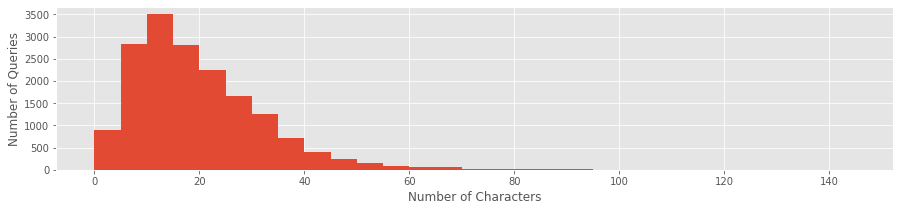

time: 15.2 s


In [48]:
d_max = qlog['length'].max()
bin_width = 5

qlog.drop_duplicates(subset='query')['length'] \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width))
plt.xlabel("Number of Characters")
plt.ylabel("Number of Queries")
plt.show()

## Distribution of number of terms per query

In [49]:
qlog['terms'] = qlog['query'].map(lambda q: q.split()); qlog[['query', 'terms']]

,query,terms
64767,Nuno Duarte Ribeiro da Silva Fonseca Oliveira,"[Nuno, Duarte, Ribeiro, da, Silva, Fonseca, Ol..."
38025,i123,[i123]
58511,validação de diploma,"[validação, de, diploma]"
58512,recinhecimento de diploma,"[recinhecimento, de, diploma]"
...,...,...
64635,Exames,[Exames]
64636,Exames,[Exames]
55329,CANDIDATURA,[CANDIDATURA]
38971,Caroline barbosa,"[Caroline, barbosa]"


time: 67.9 ms


In [50]:
qlog['num_terms'] = qlog['terms'].map(len); qlog[['query', 'num_terms']]

,query,num_terms
64767,Nuno Duarte Ribeiro da Silva Fonseca Oliveira,7
38025,i123,1
58511,validação de diploma,3
58512,recinhecimento de diploma,3
...,...,...
64635,Exames,1
64636,Exames,1
55329,CANDIDATURA,1
38971,Caroline barbosa,2


time: 33.4 ms


In [51]:
qlog['num_terms'].describe()

count    70178.000000
mean         2.515632
std          1.650658
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         22.000000
Name: num_terms, dtype: float64

time: 9.84 ms


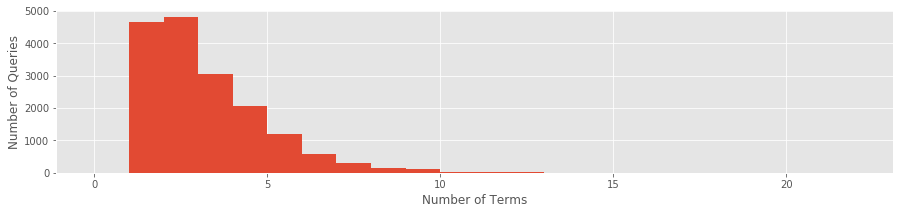

time: 238 ms


In [52]:
d_max = qlog['num_terms'].max()
bin_width = 1

qlog.drop_duplicates(subset='query')['num_terms'] \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width))
plt.xlabel("Number of Terms")
plt.ylabel("Number of Queries")
plt.show()

## Total number of terms

In [229]:
terms = pd.Series(flatten(qlog['terms'].values.tolist()))
pd.DataFrame({ 'num_terms': terms.nunique() }, index=['stat']).T

,stat
num_terms,11958


time: 360 ms


## Distribution of average number of terms over time

In [53]:
expanded_terms = qlog[['date', 'terms']] \
    .set_index('date')['terms'] \
    .apply(pd.Series) \
    .stack()

time: 21.4 s


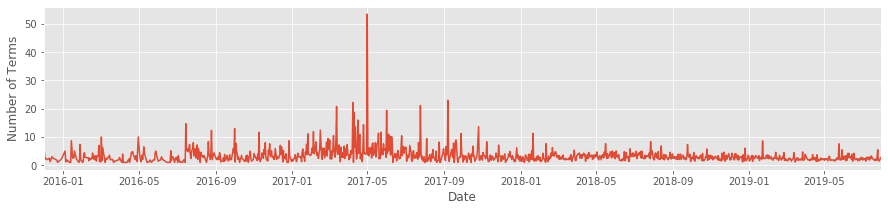

time: 610 ms


In [54]:
term_count = expanded_terms \
    .groupby('date') \
    .value_counts()

d_max = term_count.max()
bin_width = 1

term_count \
    .groupby(level=0) \
    .mean() \
    .plot()
plt.xlabel('Date')
plt.ylabel('Number of Terms')
plt.show()

## Term popularity over time for top 10 terms

In [55]:
vec = TfidfVectorizer()
X = vec.fit_transform(qlog['query'])
vocab = vec.get_feature_names()
top_terms = pd.DataFrame(X.toarray(), columns=vocab) \
    .drop(stopwords_per_lang[lang].intersection(vocab), axis=1) \
    .mean() \
    .sort_values(ascending=False)

top_terms[:5]

informática     0.071281
química         0.059198
estudante       0.058794
devezas         0.024501
departamento    0.017261
dtype: float64

time: 20.3 s


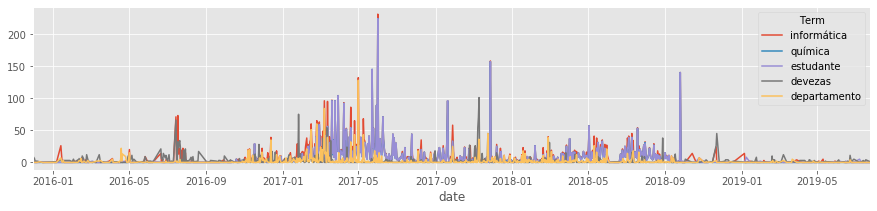

time: 881 ms


In [56]:
term_cout_over_time = pd.DataFrame(expanded_terms[expanded_terms.isin(top_terms[:5].index)], columns=['term']) \
    .reset_index() \
    .groupby(['date', 'term']) \
    .count() \
    .rename({'level_1': 'count'}, axis=1) \
    .unstack() \
    .fillna(0)

term_cout_over_time.columns = term_cout_over_time.columns.droplevel()

term_cout_over_time.loc[:, top_terms[:5].index] \
    .plot()
plt.legend(title='Term')
plt.show()

# Entity-level analysis

Our analysis of entities includes:

- Entity distributions per class
- Entity distributions over time for top entities

It also includes higher order analyses, further described in each of the following sections:

- Entity-query-level analysis
- Entity-topic-level analysis
- Entity-session-level analysis
- Entity-term-level analysis
- Entity-entity level analysis

## Detecting entities

We identified entities taking advantage of the `AhoCorasickEntityExtractor` class available in [Army ANT](https://github.com/feup-infolab/army-ant). We copied [aho_corasick_entity_extractor.py](../../edit/query_log_analysis/aho_corasick_entity_extractor.py) to the notebook workspace and edited it to be usable as a standalone dependency. We then used the English DBpedia `rdfs:label` for entities with the class `dbo:Person`, `dbo:Organisation` and `dbp:Place` as the dictionary.

In [57]:
from aho_corasick_entity_extractor import AhoCorasickEntityExtractor

lists_per_lang = {
    'en': {
        'person': 'data/entity_lists/pt_dbpedia_person.txt',
        'organization': 'data/entity_lists/pt_dbpedia_organization.txt',
        'place': 'data/entity_lists/pt_dbpedia_place.txt'
    },
    'pt': {
        'person': 'data/entity_lists/en_dbpedia_person.txt',
        'organization': 'data/entity_lists/en_dbpedia_organization.txt',
        'place': 'data/entity_lists/en_dbpedia_place.txt'
    }
}

ac = {
    'person': AhoCorasickEntityExtractor(list_path=lists_per_lang[lang]['person']),
    'organization': AhoCorasickEntityExtractor(list_path=lists_per_lang[lang]['organization']),
    'place': AhoCorasickEntityExtractor(list_path=lists_per_lang[lang]['place'])
}

time: 13.5 s


In [58]:
qlog.iloc[19]['query']

'estudante química informática'

time: 24 ms


In [59]:
from collections import OrderedDict
from functools import reduce

for d_class in ac.keys():
    qlog[d_class] = None

    for i in range(len(qlog)):
        query = qlog.iloc[i]['query']
        entities = ac[d_class].extract(query)
        
        for entity in entities:
            if qlog.loc[i, d_class] is None:
                qlog.at[i, d_class] = [entity]
            else:
                qlog.at[i, d_class].append(entity)

qlog

,index,user_id,query,timestamp,click_rank,click_url,click_timestamp,type,date,hour,...,month,category,topic,session_id,length,terms,num_terms,person,organization,place
64767,40465,0003984c5ce5e789c92f733b5c2727ae,Nuno Duarte Ribeiro da Silva Fonseca Oliveira,2019-05-16 12:29:16.826,NaN,NaN,NaT,query,2019-05-16,12,...,5,business,maria silva pedro ferreira santos,1,45,"[Nuno, Duarte, Ribeiro, da, Silva, Fonseca, Ol...",7,None,None,None
38025,19333,0006e9e119778b84f397655e2bf26382,i123,2018-06-22 14:11:06.350,NaN,NaN,NaT,query,2018-06-22,14,...,6,business,informática estudante química departamento eng...,2,4,[i123],1,None,None,None
58511,34914,00081ee4834fbf52e2fa52a5686c169c,validação de diploma,2019-03-06 13:20:22.946,NaN,NaN,NaT,query,2019-03-06,13,...,3,entertainment,curso mudança candidatura par boletim,3,21,"[validação, de, diploma]",3,None,None,None
58512,34915,00081ee4834fbf52e2fa52a5686c169c,recinhecimento de diploma,2019-03-06 13:20:49.122,NaN,NaN,NaT,query,2019-03-06,13,...,3,entertainment,curso mudança candidatura par boletim,3,25,"[recinhecimento, de, diploma]",3,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64635,40346,ffee9b7ce28d4b5f8b89f45320ecc17d,Exames,2019-05-15 15:45:24.042,NaN,NaN,NaT,query,2019-05-15,15,...,5,business,informática estudante química departamento eng...,19115,6,[Exames],1,None,None,None
64636,26687,ffee9b7ce28d4b5f8b89f45320ecc17d,Exames,2019-05-15 15:45:28.458,5.0,https://sigarra.up.pt/icbas/pt/noticias_geral....,2019-05-15 15:45:28.458,click,2019-05-15,15,...,5,business,informática estudante química departamento eng...,19115,6,[Exames],1,None,None,None
55329,31965,fff2c8a92fafcef6e233c8811dffa129,CANDIDATURA,2019-02-07 13:33:43.820,NaN,NaN,NaT,query,2019-02-07,13,...,2,business,informática estudante química departamento eng...,19116,11,[CANDIDATURA],1,None,None,None
38971,21426,fff6f4e5e0511d593a79b676c65d5a6d,Caroline barbosa,2018-07-02 01:08:28.150,1.0,NaN,2018-07-02 01:08:28.150,click,2018-07-02,1,...,7,entertainment,maria silva pedro ferreira santos,19117,16,"[Caroline, barbosa]",2,None,None,None


time: 1min 6s


## Total number of entities and distinct entities

In [67]:
entities = qlog[['person', 'organization', 'place']].values.tolist()  # select all entity lists
entities = [[x if x else [] for x in d] for d in entities]            # replace None by empty list
entities = [[x for sl2 in sl for x in sl2 if sl2] for sl in entities] # flatten row lists

qlog['entities'] = None
for i, e in enumerate(entities):
    qlog.at[i, 'entities'] = e if len(e) > 0 else None

time: 1.37 s


In [225]:
entities = pd.Series(flatten(qlog['entities'].values.tolist()))
pd.DataFrame({ 'num_entities': len(entities), 'num_distinct_entities': entities.nunique() }, index=['stat']).T

,stat
num_entities,5580
num_distinct_entities,543


time: 136 ms


## Entity distributions per class

In [60]:
qlog_entities = pd.DataFrame(columns=['entity', 'class', 'count'])

for d_class in ac.keys():
    entity_count = pd.DataFrame({
            'entity': list(itertools.chain(*filter(lambda d: d is not None, qlog[d_class]))),
            'class': d_class
        }) \
        .groupby(['entity', 'class']) \
        .size() \
        .reset_index() \
        .rename({0: 'count'}, axis='columns')
    
    qlog_entities = qlog_entities.append(entity_count)

time: 72.1 ms


### All classes

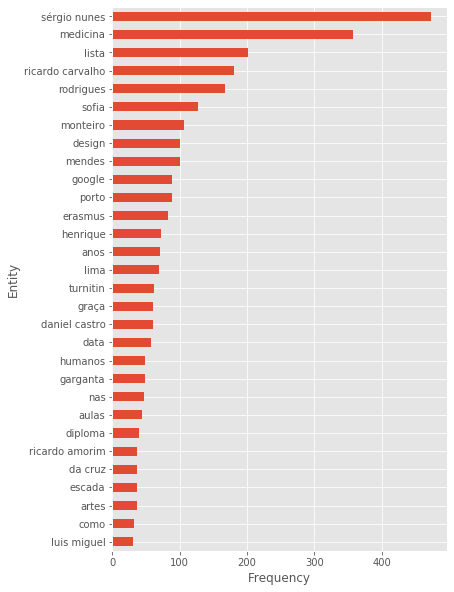

time: 552 ms


In [61]:
plt.rc('figure', figsize=[6, 10])

qlog_entities[['entity', 'count']] \
    .groupby('entity') \
    .sum() \
    .reset_index() \
    .sort_values(by='count', ascending=False) \
    .head(30) \
    .plot(kind='barh', x='entity', y='count', legend=False)

plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

### Person

In [62]:
def plot_entities_by_class(qlog_entities, d_class):
    plt.rc('figure', figsize=[6, 10])

    qlog_entities[qlog_entities['class'] == d_class] \
        .sort_values(by='count', ascending=False) \
        .head(30) \
        .plot(kind='barh', x='entity', y='count', legend=False)

    plt.xlabel('Frequency')
    plt.ylabel(d_class.title())
    plt.gca().invert_yaxis()
    plt.show()

    plt.rc('figure', figsize=DEFAULT_FIGSIZE)

time: 8.66 ms


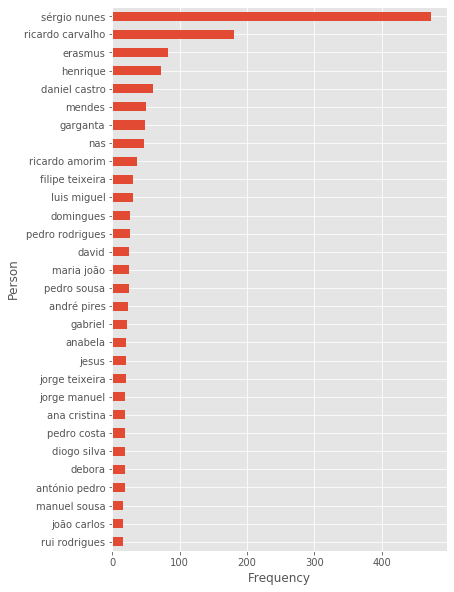

time: 440 ms


In [63]:
plot_entities_by_class(qlog_entities, 'person')

### Organization

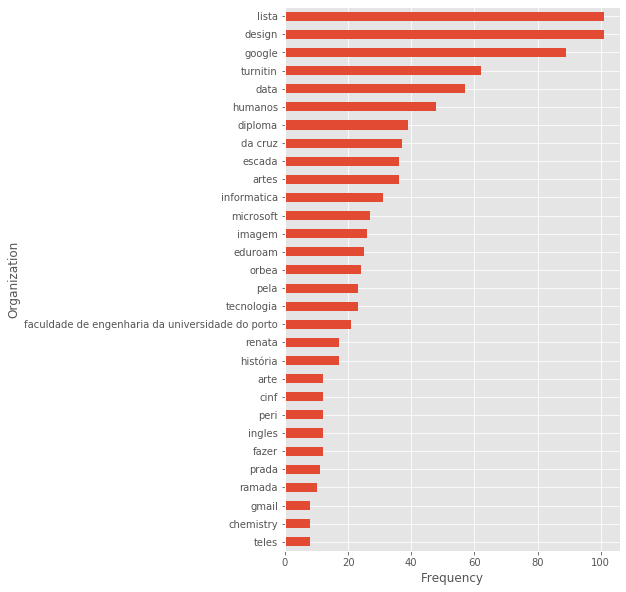

time: 826 ms


In [64]:
plot_entities_by_class(qlog_entities, 'organization')

### Place

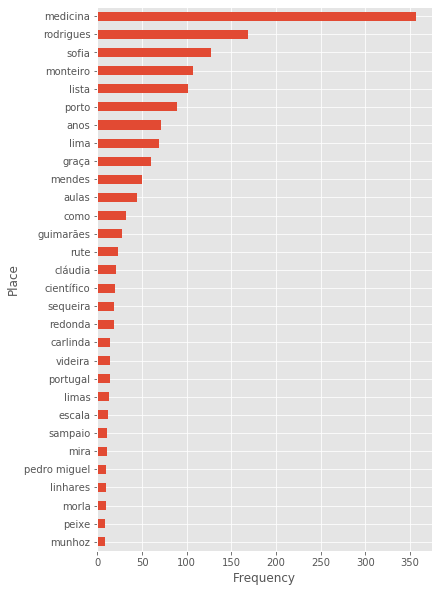

time: 534 ms


In [65]:
plot_entities_by_class(qlog_entities, 'place')

## Entity distributions over time for top-5 entities

In [66]:
def split_list_to_rows(row, row_accumulator, target_column):
    if row[target_column] == None:
        row[target_column] = []
    for s in row[target_column]:
        new_row = row.to_dict()
        new_row[target_column] = s
        row_accumulator.append(new_row)

time: 7.01 ms


In [68]:
new_rows = []
qlog[['date', 'entities']] \
    .apply(split_list_to_rows, axis=1, args = (new_rows, 'entities'))
entities_per_date = pd.DataFrame(new_rows)
entities_per_date \
    .groupby(['entities', 'date']) \
    .size() \
    .to_frame()

0
entities       date         
adelaide       2017-01-25  2
               2017-07-25  1
               2017-07-26  1
adro           2017-02-27  2
...                       ..
xanana gusmão  2019-05-25  1
yandex         2019-05-12  1
zé pedro       2018-08-06  1
ângelo martins 2018-12-22  3

[2913 rows x 1 columns]

time: 3.59 s


In [69]:
qlog_entities_over_time = pd.DataFrame(columns=['entity', 'class', 'count'])

for d_class in ac.keys():
    new_rows = []
    qlog[['date', d_class]] \
        .apply(split_list_to_rows, axis=1, args = (new_rows, d_class))
    entities_per_date = pd.DataFrame(new_rows) \
        .groupby([d_class, 'date']) \
        .size() \
        .to_frame() \
        .reset_index() \
        .rename(columns={d_class: 'entity', 0: 'count'}) \
        .assign(**{'class': d_class}) \
        .set_index(['date'])

    qlog_entities_over_time = qlog_entities_over_time.append(entities_per_date[['entity', 'class', 'count']])

qlog_entities_over_time

,entity,class,count
2017-11-08,alberto gallego,person,1
2018-02-21,alberto gomes,person,9
2019-02-07,alberto saavedra,person,1
2016-12-31,alexandre valente,person,1
...,...,...,...
2017-11-23,videira,place,2
2018-05-22,videira,place,1
2019-03-05,videira,place,11
2019-02-20,villate,place,1


time: 11.4 s


### Person

In [70]:
top_5_person = qlog_entities[qlog_entities['class'] == 'person'] \
    .sort_values(by='count', ascending=False) \
    .head(5) \
    ['entity'].values.tolist()
top_5_person

['sérgio nunes', 'ricardo carvalho', 'erasmus', 'henrique', 'daniel castro']

time: 7.25 ms


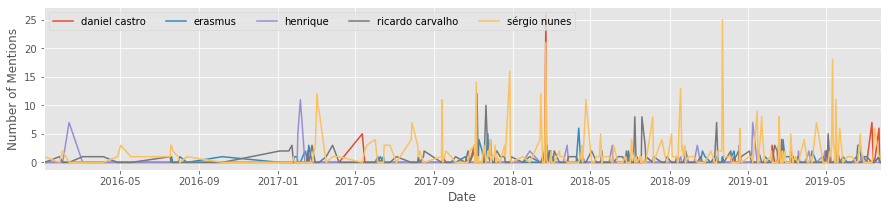

time: 390 ms


In [115]:
top_5_person_over_time = qlog_entities_over_time[qlog_entities_over_time['entity'].isin(top_5_person)] \
    [['entity', 'count']] \
    .reset_index() \
    .pivot_table(columns='entity', index='index', values=['count'], aggfunc='max') \
    .fillna(0)

top_5_person_over_time.columns = top_5_person_over_time.columns.droplevel()

top_5_person_over_time.plot()
plt.legend(loc="upper left", ncol=5)
plt.xlabel("Date")
plt.ylabel("Number of Mentions")
plt.show()

### Organization

In [119]:
top_5_organization = qlog_entities[qlog_entities['class'] == 'organization'] \
    .sort_values(by='count', ascending=False) \
    .head(5) \
    ['entity'].values.tolist()
top_5_organization

['lista', 'design', 'google', 'turnitin', 'data']

time: 6.17 ms


In [120]:
top_5_organization_over_time = qlog_entities_over_time[qlog_entities_over_time['entity'].isin(top_5_organization)] \
    [['entity', 'count']] \
    .reset_index() \
    .pivot_table(columns='entity', index='index', values=['count'], aggfunc='max') \
    .fillna(0)
top_5_organization_over_time

count                             
entity      data design google lista turnitin
index                                        
2016-02-03   0.0    0.0    2.0   0.0      0.0
2016-04-20   0.0    1.0    0.0   0.0      0.0
2016-04-21   0.0    1.0    0.0   0.0      0.0
2016-05-02   0.0    1.0    0.0   0.0      0.0
...          ...    ...    ...   ...      ...
2019-07-03   0.0    0.0    1.0   0.0      0.0
2019-07-09   0.0    0.0    1.0   0.0      5.0
2019-07-14   7.0    0.0    0.0   0.0      1.0
2019-07-15   0.0    1.0    0.0   0.0      0.0

[112 rows x 5 columns]

time: 77.6 ms


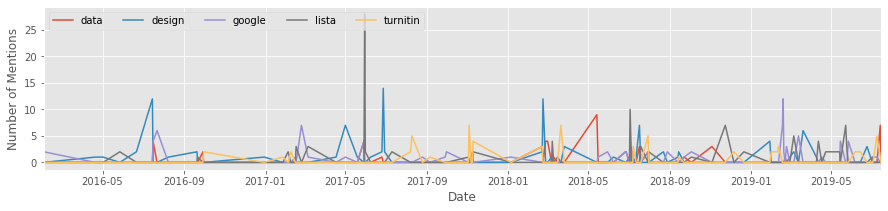

time: 405 ms


In [121]:
top_5_organization_over_time = qlog_entities_over_time[qlog_entities_over_time['entity'].isin(top_5_organization)] \
    [['entity', 'count']] \
    .reset_index() \
    .pivot_table(columns='entity', index='index', values=['count'], aggfunc='max') \
    .fillna(0)

top_5_organization_over_time.columns = top_5_organization_over_time.columns.droplevel()

top_5_organization_over_time.plot()
plt.legend(loc="upper left", ncol=5)
plt.xlabel("Date")
plt.ylabel("Number of Mentions")
plt.show()

### Place

In [122]:
top_5_place = qlog_entities[qlog_entities['class'] == 'place'] \
    .sort_values(by='count', ascending=False) \
    .head(5) \
    ['entity'].values.tolist()
top_5_place

['medicina', 'rodrigues', 'sofia', 'monteiro', 'lista']

time: 6.76 ms


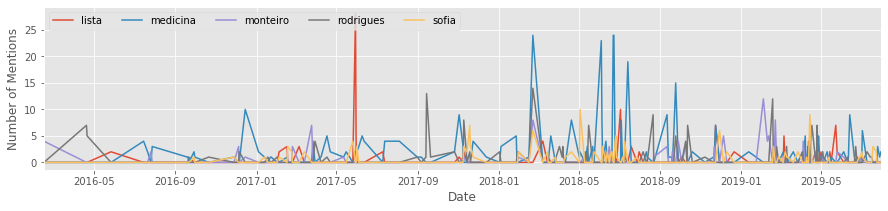

time: 398 ms


In [123]:
top_5_place_over_time = qlog_entities_over_time[qlog_entities_over_time['entity'].isin(top_5_place)] \
    [['entity', 'count']] \
    .reset_index() \
    .pivot_table(columns='entity', index='index', values=['count'], aggfunc='max') \
    .fillna(0)

top_5_place_over_time.columns = top_5_place_over_time.columns.droplevel()

top_5_place_over_time.plot()
plt.legend(loc="upper left", ncol=5)
plt.xlabel("Date")
plt.ylabel("Number of Mentions")
plt.show()

In the following sections, we expand the entity-level analysis by combining them with additional levels. In particular, we build local entity graphs from mentioned entities in a query, in queries with the same topic, or in a session to gain further insights into user search behavior.

## Building and characterizing entity graph from Simple Wikipedia

We use the [Simple English Wikipedia Link Graph with Clickstream Transitions 2018-12](https://rdm.inesctec.pt/dataset/cs-2018-004) to analyze the data from DBpedia. On one side, this graph only contains a low number of entities from Wikipedia. On the other side, it's easier to load and process in memory, conveniently supporting this analysis, that can later on be scaled up to a larger Wikipedia link graph.

In [124]:
g = igraph.read('data/simplewiki_link_graph-201812.gml', format='gml')
g.vs['label'] = [label.lower() for label in g.vs['label']]

time: 48.4 s


In [125]:
g.vs['in'] = g.indegree()
g.vs['in'] = g.vs['in'] / np.sum(g.vs['in']) # indegree centrality (i.e., normalized)
g.vs['pr'] = g.pagerank()

time: 2.72 s


In [202]:
def compute_stats(graph=None, include_distance_based=False):
    if graph is None:
        graph = g
    
    components = graph.components()
    
    stats = {
        'vertices': graph.vcount(),
        'edges': graph.ecount(),
        'avg_clust_coef': graph.transitivity_undirected(),
        'density': graph.density(),
        'num_cc': len(components),
        'avg_cc_size': np.mean(components.sizes()),
        'stdev_cc_size': np.std(components.sizes())
    }
    
    if include_distance_based:
        stats['diameter'] = graph.diameter()
        stats['avg_path_len'] = graph.average_path_length()
    
    return pd.Series(stats)

g_stats = compute_stats(); g_stats.round(2)

vertices           897577.00
edges             6986460.00
avg_clust_coef          0.26
density                 0.00
num_cc             743499.00
avg_cc_size             1.21
stdev_cc_size         177.54
dtype: float64

time: 13.2 s


## Building and visualizing entity subgraphs induced by a set of entities

We extract the induced entity subgraph for a set of entities, including all edges between the respective entity nodes. We also annotate and color source entity nodes, as well as shortest path edges (indiscriminately for any shortest path edges).

In [127]:
def entity_subgraph(entities, sample=None, ignore_warn=False):
    if sample is not None:
        entities = np.random.choice(list(entities), size=np.min([len(entities), sample]), replace=False)

    v_entities = g.vs.select(label_in=entities)
    
    s_paths = []
    for v_entity in v_entities:
        s_paths.extend(g.get_shortest_paths(v_entity, to=v_entities))

    sg = g.induced_subgraph([v for s_path in s_paths for v in s_path])
    
    sg.vs['is_source'] = False
    sg.vs['color'] = '#85c1e9'
    sg.es['arrow_size'] = 0.5

    sources = sg.vs.select(label_in=v_entities['label'])
    sources['is_source'] = True
    sources['color'] = '#f7dc6f'
    
    sp_edges = []
    for s_path in s_paths:
        if len(s_path) < 2:
            continue

        for s_idx, t_idx in zip(range(len(s_path)-1), range(1, len(s_path))):
            source = sg.vs.find(label=g.vs[s_path[s_idx]]['label'])
            target = sg.vs.find(label=g.vs[s_path[t_idx]]['label'])

            try:
                sp_edge = sg.es.find(_source=source.index, _target=target.index)
                sp_edge['arrow_size'] = 0.75
                sp_edge['width'] = 1.5
                sp_edge['color'] = '#f7dc6f'
                sp_edges.append(sp_edge)
            except:
                if not ignore_warn:
                    warnings.warn("Edge linking %s and %s not found" % (source['label'], target['label']))

    return sg

time: 143 ms


In [128]:
def plot_subgraph(sg, large=False):
    if large:
        bbox = (640, 480)
        margin = (50, 100, 50, 100)
    else:
        bbox = (320, 240)
        margin = (25, 50, 25, 50)

    return igraph.plot(sg, bbox=bbox, margin=margin, vertex_size=10, vertex_label_size=10, vertex_label_dist=1.5)

time: 8.24 ms


# Entity-query-level analysis

- Distribution of entities per query
- Distribution of global entity importance (PageRank) per query
- Distribution of local entity importance (PageRank) per query
- Number of distinct queries per entity

## Distribution of entities per query

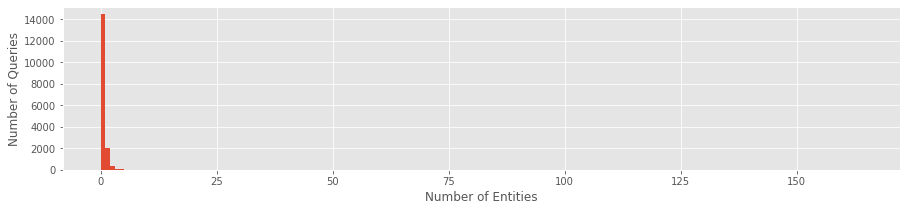

time: 1.95 s


In [129]:
entities_per_query = qlog[['query', 'entities']] \
    .groupby('query') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 1

entities_per_query \
    .plot(kind='hist', bins=range(0, entities_per_query.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Queries")
plt.show()

## Preparing entity subgraphs per query

In [130]:
qlog[qlog['num_terms'] < qlog['num_terms'].max()]

,index,user_id,query,timestamp,click_rank,click_url,click_timestamp,type,date,hour,...,category,topic,session_id,length,terms,num_terms,person,organization,place,entities
64767,40465,0003984c5ce5e789c92f733b5c2727ae,Nuno Duarte Ribeiro da Silva Fonseca Oliveira,2019-05-16 12:29:16.826,NaN,NaN,NaT,query,2019-05-16,12,...,business,maria silva pedro ferreira santos,1,45,"[Nuno, Duarte, Ribeiro, da, Silva, Fonseca, Ol...",7,None,None,None,None
38025,19333,0006e9e119778b84f397655e2bf26382,i123,2018-06-22 14:11:06.350,NaN,NaN,NaT,query,2018-06-22,14,...,business,informática estudante química departamento eng...,2,4,[i123],1,None,None,None,None
58511,34914,00081ee4834fbf52e2fa52a5686c169c,validação de diploma,2019-03-06 13:20:22.946,NaN,NaN,NaT,query,2019-03-06,13,...,entertainment,curso mudança candidatura par boletim,3,21,"[validação, de, diploma]",3,None,None,None,None
58512,34915,00081ee4834fbf52e2fa52a5686c169c,recinhecimento de diploma,2019-03-06 13:20:49.122,NaN,NaN,NaT,query,2019-03-06,13,...,entertainment,curso mudança candidatura par boletim,3,25,"[recinhecimento, de, diploma]",3,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64635,40346,ffee9b7ce28d4b5f8b89f45320ecc17d,Exames,2019-05-15 15:45:24.042,NaN,NaN,NaT,query,2019-05-15,15,...,business,informática estudante química departamento eng...,19115,6,[Exames],1,None,None,None,None
64636,26687,ffee9b7ce28d4b5f8b89f45320ecc17d,Exames,2019-05-15 15:45:28.458,5.0,https://sigarra.up.pt/icbas/pt/noticias_geral....,2019-05-15 15:45:28.458,click,2019-05-15,15,...,business,informática estudante química departamento eng...,19115,6,[Exames],1,None,None,None,None
55329,31965,fff2c8a92fafcef6e233c8811dffa129,CANDIDATURA,2019-02-07 13:33:43.820,NaN,NaN,NaT,query,2019-02-07,13,...,business,informática estudante química departamento eng...,19116,11,[CANDIDATURA],1,None,None,None,None
38971,21426,fff6f4e5e0511d593a79b676c65d5a6d,Caroline barbosa,2018-07-02 01:08:28.150,1.0,NaN,2018-07-02 01:08:28.150,click,2018-07-02,1,...,entertainment,maria silva pedro ferreira santos,19117,16,"[Caroline, barbosa]",2,None,None,None,None


time: 123 ms


In [131]:
def entities_from_query(query):
    return set(flatten(
        qlog[qlog['query'] == query] \
            ['entities'].values.tolist()))

entities_from_query('aberdeen police department in maryland')

set()

time: 11.3 ms


In [132]:
@memory.cache
def get_entity_subgraphs_by_query(queries):
    eg = {}
    for query in progressbar.progressbar(queries):
        entities = entities_from_query(query)
        if entities:
            eg[query] = entity_subgraph(entities, ignore_warn=True)
            eg[query].vs['lpr'] = eg[query].pagerank()    
    return eg

eg = get_entity_subgraphs_by_query(qlog['query'].unique())

N/A% (0 of 17002) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--/home/jldevezas/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Couldn't reach some vertices at structural_properties.c:740
  if __name__ == '__main__':
100% (17002 of 17002) |##################| Elapsed Time: 0:09:40 Time:  0:09:40


time: 9min 41s


## Visualizing entity subgraphs for queries

In [134]:
#plot_subgraph(eg['aberdeen police department in maryland'])

time: 529 µs


## Distribution of global entity importance (PageRank) per query

In [135]:
all_queries_pr = pd.concat(
    pd.DataFrame({ 'query': query, 'pr': eg[query].vs['pr'], 'lpr': eg[query].vs['lpr'] })
    for query in eg.keys())

all_queries_pr = all_queries_pr \
    .groupby('query') \
    .mean()

all_queries_pr

,pr,lpr
query,,
Reabilitação psicossocial e recovery na doença mental,1.587206e-06,1.0
comércio internacional,6.576308e-07,1.0
maiores 23,3.958842e-06,1.0
pffonseca@reit.up.pt,9.701015e-06,1.0
...,...,...
ângelo martins,7.385808e-07,1.0
época especial,1.146178e-06,1.0
época especial,4.568679e-05,1.0
​​up201306002,1.587206e-06,1.0


time: 2.65 s


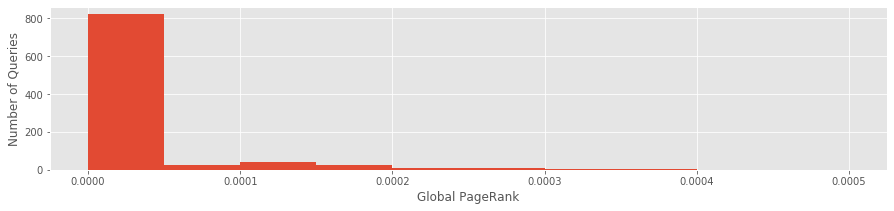

time: 266 ms


In [136]:
d_max = all_queries_pr['pr'].max()
bin_width = 0.00005

all_queries_pr['pr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Global PageRank')
plt.ylabel('Number of Queries')
plt.show()

## Distribution of local entity importance (PageRank) per query

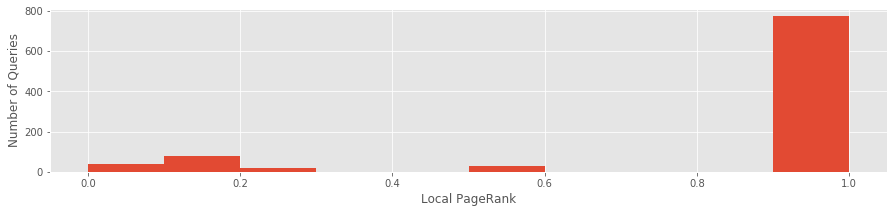

time: 221 ms


In [137]:
d_max = all_queries_pr['lpr'].max()
bin_width = 0.1

all_queries_pr['lpr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Local PageRank')
plt.ylabel('Number of Queries')
plt.show()

## Number of distinct queries per entity (top 25)

In [138]:
queries_per_entity = qlog[['query', 'entities']] \
    .groupby('query') \
    .first() \
    .reset_index()

null_idx = queries_per_entity.index[queries_per_entity['entities'].isnull()]

for idx in null_idx:
    queries_per_entity['entities'].at[idx] = []

queries_per_entity = pd.DataFrame([
    (row.query, entity) for row in queries_per_entity.itertuples() for entity in row.entities],
    columns=['query', 'entity'])

queries_per_entity = queries_per_entity[['entity', 'query']] \
    .groupby('entity') \
    .count() \
    .sort_values(ascending=False, by='query') \
    .head(25)

queries_per_entity

,query
entity,
medicina,98
sérgio nunes,97
lista,58
ricardo carvalho,46
...,...
humanos,11
lima,11
aulas,10
como,10


time: 288 ms


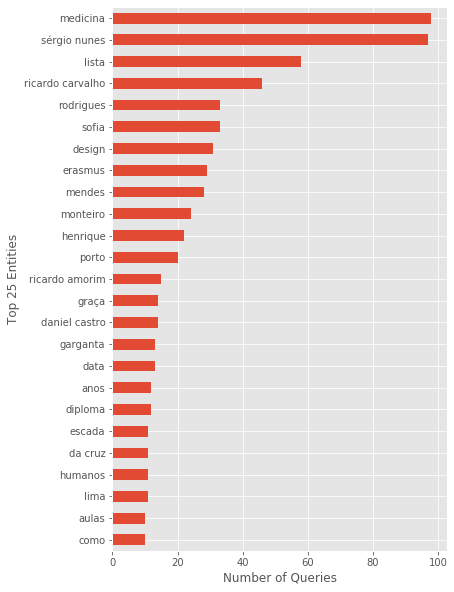

time: 357 ms


In [139]:
plt.rc('figure', figsize=[6, 10])

queries_per_entity['query'] \
    .plot(kind='barh')
plt.xlabel('Number of Queries')
plt.ylabel('Top 25 Entities')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

# Entity-topic-level analysis

- Distribution of entities per category
- Distribution of entity importance (PageRank) per category
- Distribution of categories per entity


- Distribution of entities per topic
- Distribution of distinct entities per topic
- Distribution of entity importance (PageRank) per topic
- Distribution of topics per entity

## Categories

### Distribution of entities per category

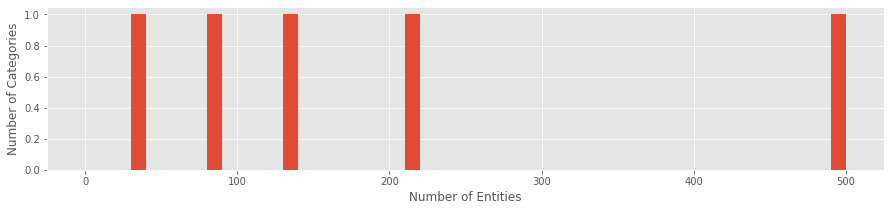

time: 515 ms


In [140]:
entities_per_category = qlog[['category', 'entities']] \
    .groupby('category') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 10

entities_per_category \
    .plot(kind='hist', bins=range(0, entities_per_category.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Categories")
plt.show()

### Preparing entity subgraphs per category

In [141]:
def entities_from_category(category):
    return set(flatten(
        qlog[qlog['category'] == category] \
            ['entities'].values.tolist()))

entities_from_category('business')

{'adelaide',
 'adro',
 'advanced',
 'agost',
 'alba',
 'albertina',
 'alberto gallego',
 'alberto gomes',
 'alexandre valente',
 'amul',
 'amélia veiga',
 'américo',
 'ana carolina',
 'ana cristina',
 'ana nogueira',
 'anabela',
 'andara',
 'andré carvalho',
 'andré castro',
 'andré da silva',
 'andré oliveira',
 'andré pires',
 'andré santos',
 'anos',
 'antonio braga',
 'antonio carvalho',
 'antónio araújo',
 'antónio manuel',
 'antónio pacheco',
 'antónio pedro',
 'antónio soares',
 'antónio sousa',
 'antónio vieira',
 'areosa',
 'armando santos',
 'arte',
 'artemisa',
 'artes',
 'augusto da silva',
 'augusto santos',
 'augusto santos silva',
 'augusto silva',
 'aulas',
 'baidu',
 'bar',
 'barata',
 'barreira',
 'basto',
 'beck',
 'belo',
 'bernardo campos',
 'bernardo faria',
 'bernardo lopes',
 'bernardo sousa',
 'blom',
 'boa',
 'bruno alves',
 'bruno ramos',
 'burgos',
 'busca',
 'business',
 'cabral ferreira',
 'cadaver',
 'canales',
 'canário',
 'carini',
 'carlinda',
 'carlos

time: 132 ms


In [142]:
@memory.cache
def get_entity_subgraphs_by_category(categories, sample=None):
    eg = {}
    for category in progressbar.progressbar(categories):
        entities = entities_from_category(category)
        if entities:
            eg[category] = entity_subgraph(entities, sample=sample, ignore_warn=True)
            eg[category].vs['lpr'] = eg[category].pagerank()    
    return eg

eg = get_entity_subgraphs_by_category(qlog['category'].unique(), sample=100)

N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/home/jldevezas/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Couldn't reach some vertices at structural_properties.c:740
  if __name__ == '__main__':
100% (5 of 5) |##########################| Elapsed Time: 0:00:46 Time:  0:00:46


time: 46.5 s


### Distribution of global entity importance (PageRank) per category

In [143]:
all_categories_pr = pd.concat(
    pd.DataFrame({ 'category': category, 'pr': eg[category].vs['pr'], 'lpr': eg[category].vs['lpr'] })
    for category in eg.keys())

all_categories_pr

,category,pr,lpr
0,business,2.450089e-04,0.002366
1,business,4.568679e-05,0.002307
2,business,4.829241e-04,0.015572
3,business,2.327708e-04,0.008493
...,...,...,...
146,politics,1.146178e-06,0.001626
147,politics,6.484466e-07,0.002735
148,politics,6.716314e-07,0.001397
149,politics,6.697777e-07,0.001657


time: 27.5 ms


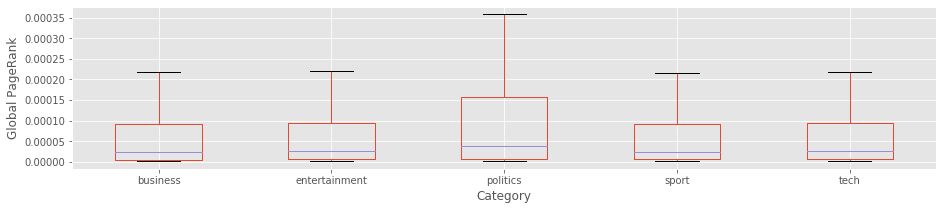

time: 257 ms


In [144]:
all_categories_pr[['category', 'pr']] \
    .boxplot(by='category', showfliers=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Global PageRank")
plt.show()

### Distribution of local entity importance (PageRank) per category

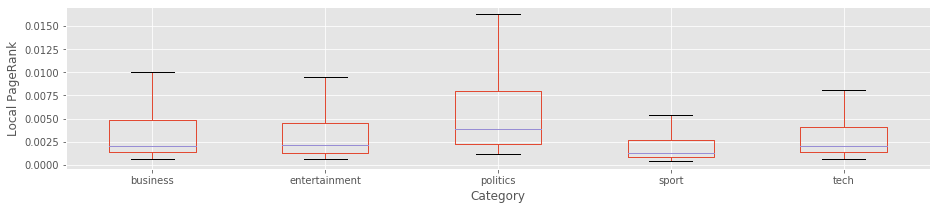

time: 236 ms


In [145]:
all_categories_pr[['category', 'lpr']] \
    .boxplot(by='category', showfliers=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Local PageRank")
plt.show()

### Distribution of categories per entity (top 25)

In [146]:
categories_per_entity = qlog[['category', 'entities']]

null_idx = categories_per_entity.index[categories_per_entity['entities'].isnull()]

for idx in null_idx:
    categories_per_entity['entities'].at[idx] = []

categories_per_entity = pd.DataFrame([
    (row.category, entity) for row in categories_per_entity.itertuples() for entity in row.entities],
    columns=['category', 'entity'])

categories_per_entity = categories_per_entity[['entity', 'category']] \
    .groupby('entity') \
    .nunique()[['category']] \
    .sort_values(ascending=False, by="category") \
    .head(25)

categories_per_entity

,category
entity,
rodrigues,5
porto,5
erasmus,5
anos,5
...,...
jorge teixeira,4
lista,4
pela,4
ricardo amorim,4


time: 778 ms


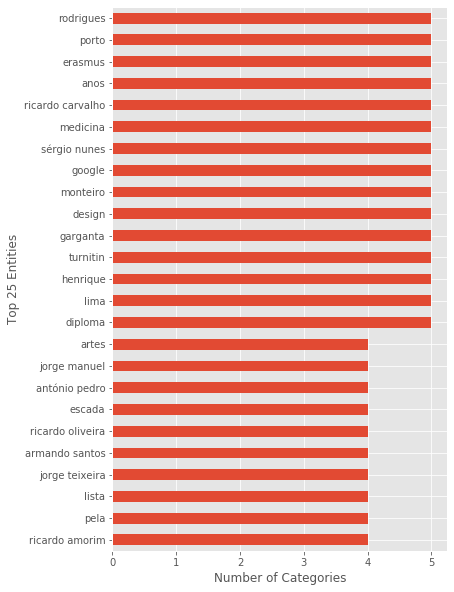

time: 304 ms


In [147]:
plt.rc('figure', figsize=[6, 10])

categories_per_entity['category'] \
    .plot(kind='barh')
plt.xlabel('Number of Categories')
plt.ylabel('Top 25 Entities')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Topics

### Distribution of entities per topic

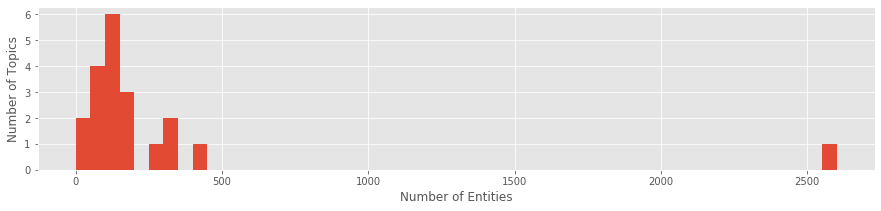

time: 465 ms


In [148]:
entities_per_topic = qlog[['topic', 'entities']] \
    .groupby('topic') \
    .apply(lambda df: len(list(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 50

entities_per_topic \
    .plot(kind='hist', bins=range(0, entities_per_topic.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Topics")
plt.show()

### Distribution of distinct entities per topic

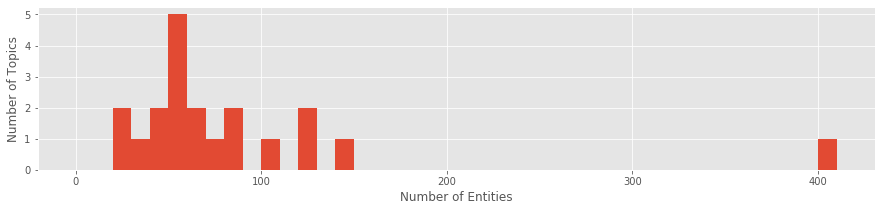

time: 361 ms


In [149]:
entities_per_topic = qlog[['topic', 'entities']] \
    .groupby('topic') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 10

entities_per_topic \
    .plot(kind='hist', bins=range(0, entities_per_topic.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Topics")
plt.show()

### Preparing entity subgraphs per topic

In [150]:
topic_count = qlog[['topic', 'query']] \
    .groupby('topic') \
    .count() \
    .rename(columns={'query': 'count'}) \
    .sort_values(by='count')

time: 25.5 ms


In [151]:
def entities_from_topic(topic):
    return set(flatten(
        qlog[qlog['topic'] == topic] \
            ['entities'].values.tolist()))

top_3_topic = topic_count.iloc[-3].name
display(top_3_topic)
entities_from_topic(top_3_topic)

'joão manuel santos jorge antónio'

{'ana cristina',
 'andré pires',
 'anos',
 'antonio carvalho',
 'antónio ferreira',
 'antónio pacheco',
 'antónio soares',
 'armando santos',
 'arte',
 'artes',
 'aude',
 'canário',
 'carlinda',
 'carlos manuel',
 'carlos teixeira',
 'cassola',
 'catarina reis',
 'china',
 'científico',
 'cinf',
 'cláudia',
 'como',
 'computer science',
 'da cruz',
 'daniel castro',
 'data',
 'david',
 'david miranda',
 'deep learning',
 'design',
 'diploma',
 'domingues',
 'eduardo almeida',
 'erasmus',
 'escada',
 'escala',
 'fernanda ferreira',
 'filipe teixeira',
 'gaahl',
 'gabriel',
 'garganta',
 'gomes carneiro',
 'google',
 'guimarães',
 'gustavo henrique',
 'henrique',
 'história',
 'humanos',
 'imagem',
 'informatica',
 'inácio martins',
 'jacob',
 'jesus',
 'josé moreira',
 'joão garcia',
 'joão josé',
 'joão neto',
 'joão reis',
 'joão sousa',
 'joão tiago',
 'larissa',
 'lima',
 'linhares',
 'lista',
 'luis miguel',
 'madeira',
 'manuel martins',
 'manuel sousa',
 'maranhão',
 'marcação',


time: 25.1 ms


In [152]:
@memory.cache
def get_entity_subgraphs_by_topic(topics):
    eg = {}
    for topic in progressbar.progressbar(topics):
        entities = entities_from_topic(topic)
        if entities:
            eg[topic] = entity_subgraph(entities, ignore_warn=True)
            eg[topic].vs['lpr'] = eg[topic].pagerank()    
    return eg

eg = get_entity_subgraphs_by_topic(qlog['topic'].unique())

N/A% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/home/jldevezas/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Couldn't reach some vertices at structural_properties.c:740
  if __name__ == '__main__':
100% (20 of 20) |########################| Elapsed Time: 0:06:38 Time:  0:06:38


time: 6min 40s


### Visualizing entity subgraphs for topics

'mestrado integrado ciências operacional abel'

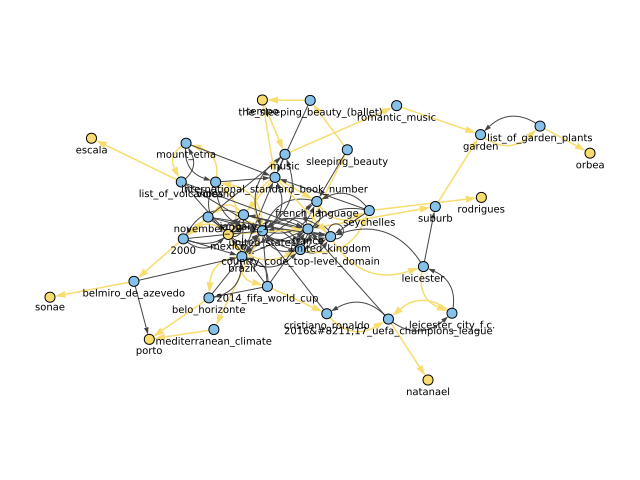

time: 168 ms


In [153]:
bottom_topic = topic_count.iloc[0].name
display(bottom_topic)
plot_subgraph(eg[bottom_topic], large=True)

### Distribution of global entity importance (PageRank) per topic

In [154]:
all_topics_pr = pd.concat(
    pd.DataFrame({ 'topic': topic, 'pr': eg[topic].vs['pr'], 'lpr': eg[topic].vs['lpr'] })
    for topic in eg.keys())

all_topics_pr

,topic,pr,lpr
0,maria silva pedro ferreira santos,2.450089e-04,0.001892
1,maria silva pedro ferreira santos,4.568679e-05,0.001320
2,maria silva pedro ferreira santos,4.829241e-04,0.005614
3,maria silva pedro ferreira santos,2.327708e-04,0.003863
...,...,...,...
33,mestrado integrado ciências operacional abel,1.799067e-06,0.054752
34,mestrado integrado ciências operacional abel,1.146178e-06,0.010795
35,mestrado integrado ciências operacional abel,3.961671e-06,0.009624
36,mestrado integrado ciências operacional abel,6.484466e-07,0.029416


time: 43.6 ms


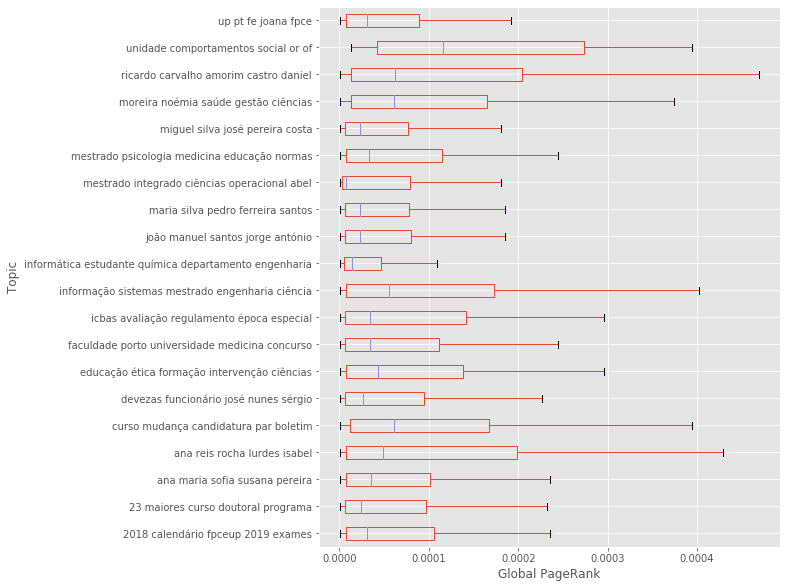

time: 635 ms


In [155]:
plt.rc('figure', figsize=[8, 10])

all_topics_pr[['topic', 'pr']] \
    .boxplot(by='topic', showfliers=False, vert=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Global PageRank")
plt.ylabel("Topic")
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

### Distribution of local entity importance (PageRank) per topic

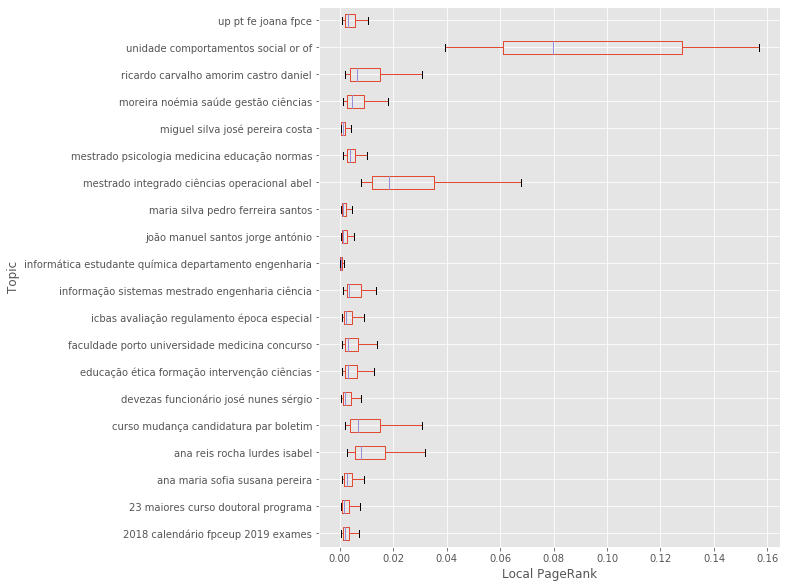

time: 636 ms


In [156]:
plt.rc('figure', figsize=[8, 10])

all_topics_pr[['topic', 'lpr']] \
    .boxplot(by='topic', showfliers=False, vert=False)
plt.title("")
plt.suptitle("")
plt.xlabel("Local PageRank")
plt.ylabel("Topic")
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

### Distribution of topics per entity (top 25)

In [157]:
topics_per_entity = qlog[['topic', 'entities']]

null_idx = topics_per_entity.index[topics_per_entity['entities'].isnull()]

for idx in null_idx:
    topics_per_entity['entities'].at[idx] = []

topics_per_entity = pd.DataFrame([
    (row.topic, entity) for row in topics_per_entity.itertuples() for entity in row.entities],
    columns=['topic', 'entity'])

topics_per_entity = topics_per_entity[['entity', 'topic']] \
    .groupby('entity') \
    .nunique()[['topic']] \
    .sort_values(ascending=False, by="topic") \
    .head(25)

topics_per_entity

,topic
entity,
sérgio nunes,20
medicina,19
ricardo carvalho,18
rodrigues,18
...,...
pedro rodrigues,12
daniel castro,12
artes,12
graça,12


time: 1.14 s


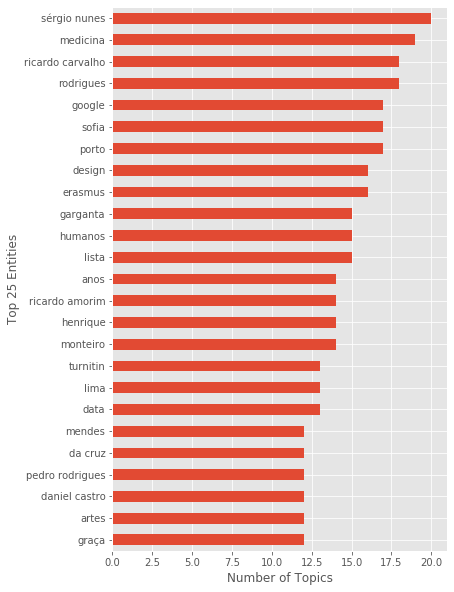

time: 322 ms


In [158]:
plt.rc('figure', figsize=[6, 10])

topics_per_entity['topic'] \
    .plot(kind='barh')
plt.xlabel('Number of Topics')
plt.ylabel('Top 25 Entities')
plt.gca().invert_yaxis()
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

# Entity-session-level analysis

- Distribution of entities per session
- Distribution of distinct entities per session


- Entity graphs for the top sessions with more entities:
  - Average distance between query entities
  - Global entity importance (PageRank)
  - Local entity importance (PageRank)
  - Global vs local PageRank


- Distribution of global entity importance (PageRank) per session
- Distribution of local entity importance (PageRank) per session


- Distribution of average number of entities per session over time
- Distribution of average entity importance (PageRank) per session over time

## Distribution of entities per session

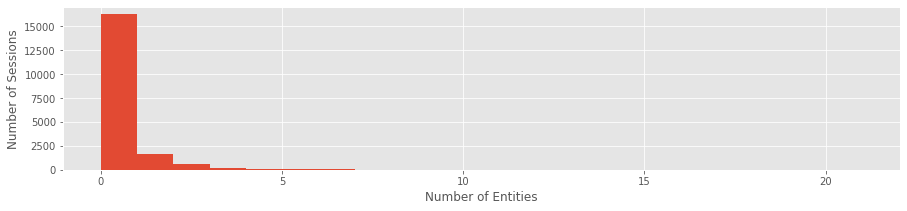

time: 1.46 s


In [159]:
entities_per_session = qlog[['session_id', 'entities']] \
    .groupby('session_id') \
    .apply(lambda df: len(list(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 1

entities_per_session \
    .plot(kind='hist', bins=range(0, entities_per_session.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Sessions")
plt.show()

## Distribution of distinct entities per session

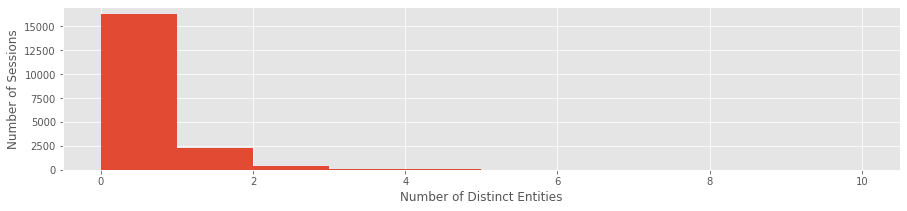

time: 1.46 s


In [160]:
distinct_entities_per_session = qlog[['session_id', 'entities']] \
    .groupby('session_id') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 1

distinct_entities_per_session \
    .plot(kind='hist', bins=range(0, distinct_entities_per_session.max() + bin_width, bin_width))
plt.xlabel("Number of Distinct Entities")
plt.ylabel("Number of Sessions")
plt.show()

## Identifying the entities for the top sessions with distinct entities

In [161]:
top_sessions = distinct_entities_per_session \
    .head()
top_sessions

session_id
3839     10
17106    10
3397     10
7304      9
2910      9
dtype: int64

time: 3.9 ms


## Preparing entity subgraphs per session

In [162]:
def entities_from_session(session_id):
    return set(flatten(
        qlog[qlog['session_id'] == session_id] \
            ['entities'].values.tolist()))

entities_from_session(2091)

set()

time: 6.89 ms


In [163]:
@memory.cache
def get_entity_subgraphs_by_session_id(session_ids):
    eg = {}
    for session_id in progressbar.progressbar(session_ids):
        entities = entities_from_session(session_id)
        if entities:
            eg[session_id] = entity_subgraph(entities, ignore_warn=True)
            eg[session_id].vs['lpr'] = eg[session_id].pagerank()    
    return eg

eg = get_entity_subgraphs_by_session_id(qlog['session_id'].unique())

N/A% (0 of 19117) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--/home/jldevezas/.pyenv/versions/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Couldn't reach some vertices at structural_properties.c:740
  if __name__ == '__main__':
100% (19117 of 19117) |##################| Elapsed Time: 0:07:56 Time:  0:07:56


time: 7min 57s


## Visualizing entity subgraphs for sessions

Below we visualize the entity graphs for two top-5 sessions (2091 and 4) and a smaller session (2080).

In [165]:
#plot_subgraph(eg[2091], large=True)

time: 870 µs


In [166]:
#plot_subgraph(eg[4], large=True)

time: 6.78 ms


In [167]:
#plot_subgraph(eg[2080])

time: 1.26 ms


## Distance between query entities

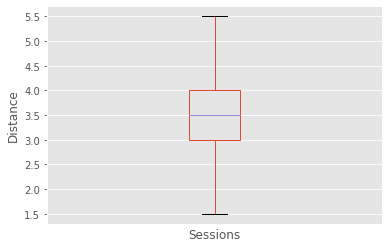

time: 292 ms


In [168]:
s_avg_dists = []
for session_id, sg in eg.items():
    s_dists = sg.shortest_paths(source=sg.vs.select(is_source=True), target=sg.vs.select(is_source=True))
    s_dists = list(filter(lambda x: x > 0, flatten(s_dists)))
    
    if len(s_dists) < 1 or np.inf in s_dists:
        continue
    
    s_avg_dist = np.mean(s_dists)
    s_avg_dists.append(s_avg_dist)

s_avg_dists = pd.DataFrame(s_avg_dists, columns=['avg_dist'])

plt.rc('figure', figsize=[6, 4])

s_avg_dists \
    .boxplot()

plt.xticks([])
plt.xlabel("Sessions")
plt.ylabel("Distance")

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

## Global entity importance (PageRank)

In [169]:
session_ids = []
pr = []
lpr = []

for session_id in top_sessions.index:
    if session_id in eg:
        for v in eg[session_id].vs:
            session_ids.append(session_id)
            pr.append(v['pr'])
            lpr.append(v['lpr'])

session_pr = pd.DataFrame({ 'session_id': session_ids, 'page_rank': pr, 'local_page_rank': lpr }) \
    .set_index('session_id')

session_pr.index = pd.Categorical(session_pr.index, categories=top_sessions.index)
session_pr.index.name = 'session_id'

time: 23.7 ms


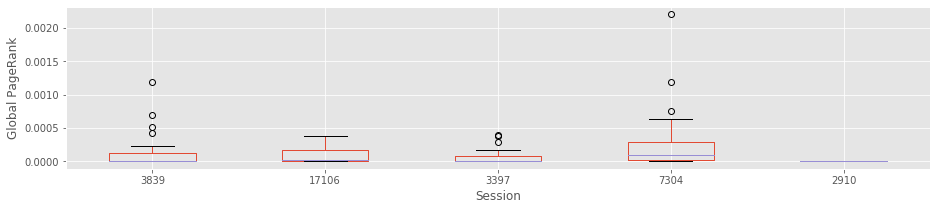

time: 304 ms


In [170]:
session_pr[['page_rank']] \
    .boxplot(by='session_id')

plt.xlabel("Session")
plt.ylabel("Global PageRank")
plt.title(None)
plt.suptitle(None)
plt.show()

## Local entity importance (PageRank)

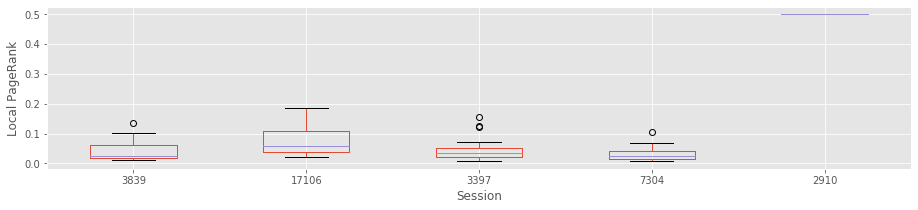

time: 265 ms


In [171]:
session_pr[['local_page_rank']] \
    .boxplot(by='session_id')

plt.xlabel("Session")
plt.ylabel("Local PageRank")
plt.title(None)
plt.suptitle(None)
plt.show()

## Global vs local PageRank

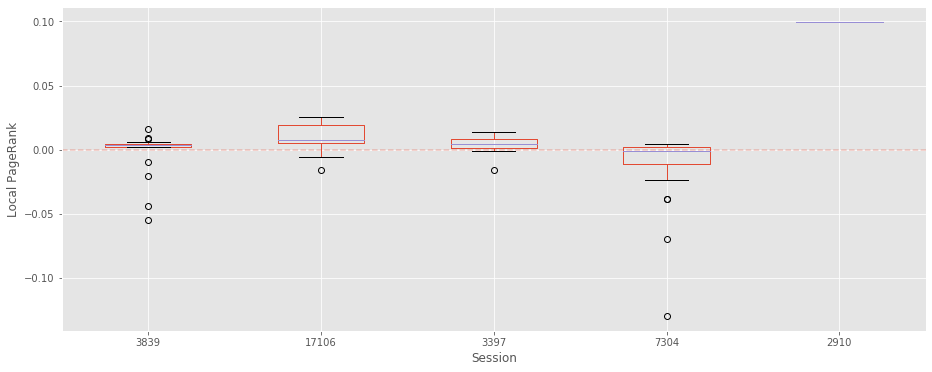

time: 362 ms


In [172]:
session_pr['norm_page_rank'] = session_pr['page_rank'] / session_pr['page_rank'].sum()
session_pr['norm_local_page_rank'] = session_pr['local_page_rank'] / session_pr['local_page_rank'].sum()
session_pr['norm_page_rank_diff'] = session_pr['norm_local_page_rank'] - session_pr['norm_page_rank']

plt.rc('figure', figsize=[DEFAULT_FIGSIZE[0], 6])

session_pr[['norm_page_rank_diff']] \
    .boxplot(by='session_id') \
    .axhline(y=0, alpha=0.3, linestyle='--')

plt.xlabel("Session")
plt.ylabel("Local PageRank")
plt.title(None)
plt.suptitle(None)
plt.show()

plt.rc('figure', figsize=DEFAULT_FIGSIZE)

**Q:** Why does session 1224 show a higher absolute difference than the remaining sessions?

**H1:** Is it because of the number of queries?

In [173]:
session_queries = qlog[qlog['entities'].map(lambda e: len(e) if e else 0) > 0][['session_id', 'query']] \
    .set_index('session_id') \
    .loc[top_sessions.index]

session_queries.index = pd.Categorical(session_queries.index, categories=top_sessions.index)
session_queries.index.name = 'session_id'

session_queries \
    .groupby(['session_id']) \
    .nunique() \
    .reset_index()

,session_id,query
0,3839,1
1,17106,10
2,3397,1
3,7304,3
4,2910,5


time: 42.9 ms


No. The behavior is simular for sessions 2091 and 1224 for the number of queries, but the highest change in PageRank was for session 1224.

**H2:** Is it because of the number of entities?

In [174]:
top_sessions \
    .reset_index() \
    .rename({ 0: 'entity' }, axis=1)

,session_id,entity
0,3839,10
1,17106,10
2,3397,10
3,7304,9
4,2910,9


time: 10.4 ms


No. The behavior was similar for sessions 2091 and 1224 in number of entities, but the highest change in PageRank was for session 1224.

**H3:** Is is because of the semantics of the queries?

In [175]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    query_count_per_session = session_queries \
        .groupby(['session_id', 'query']) \
        .size() \
        .reset_index() \
        .rename({ 0: 'count'}, axis=1) \
        .sort_values(by=['session_id', 'count'], ascending=[True, False])
    
    query_count_per_session['query_length'] = query_count_per_session['query'].map(len)
    
    display(query_count_per_session)

,session_id,query,count,query_length
0,3839,estudante química informática,13,29
9,17106,funcionário faculdade engenharia activo,2,39
1,17106,Augusto ernesto Santos silva,1,28
2,17106,Fernando Teixeira dos santos,1,28
3,17106,I123,1,4
4,17106,Ricardo Carvalho Amorim,1,23
5,17106,departamento engenharia,1,23
6,17106,departamento feup,1,17
7,17106,fernando teixeira dos santos,1,28
8,17106,funcionario ativo feup,1,22


time: 39.8 ms


Although the sample is too small, there seems to be a relation between query length and the change in PageRank. We investigate further, using the entity subgraphs for all sessions instead of the top sessions (i.e., with a higher number of distinct entities).

In [176]:
all_session_pr = pd.concat(
    pd.DataFrame({ 'session_id': session_id, 'pr': eg[session_id].vs['pr'], 'lpr': eg[session_id].vs['lpr'] })
    for session_id in eg.keys())

all_session_pr = all_session_pr \
    .set_index('session_id')

all_session_pr['pr'] = all_session_pr['pr'] / all_session_pr['pr'].sum()
all_session_pr['lpr'] = all_session_pr['lpr'] / all_session_pr['lpr'].sum()

all_session_pr = all_session_pr \
    .groupby('session_id') \
    .mean()

all_session_pr['pr_diff'] = all_session_pr['lpr'] - all_session_pr['pr']

all_session_pr = all_session_pr.merge(
    qlog[qlog['entities'].map(lambda e: len(e) if e else 0) > 0][['session_id', 'length']] \
        .groupby('session_id') \
        .mean(), on='session_id')

all_session_pr['pr_diff'].corr(all_session_pr['length'], method='spearman')

-0.024544349727214473

time: 2.79 s


Based on the mean PageRanks and query lengths per session, there is no correlation with the change in PageRanks. Since the difference is so small, this is probably a random difference that we can disregard.

## Distribution of global entity importance (PageRank) per session

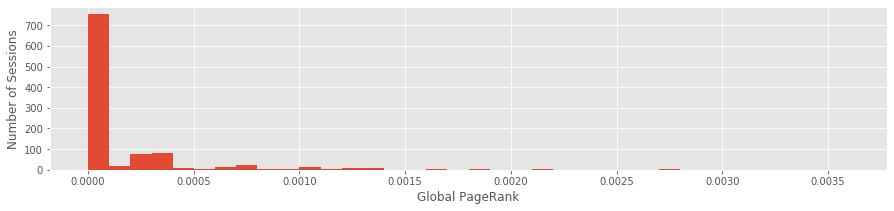

time: 273 ms


In [177]:
d_max = all_session_pr['pr'].max()
bin_width= 0.0001

all_session_pr['pr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Global PageRank')
plt.ylabel('Number of Sessions')
plt.show()

## Distribution of local entity importance (PageRank) per session

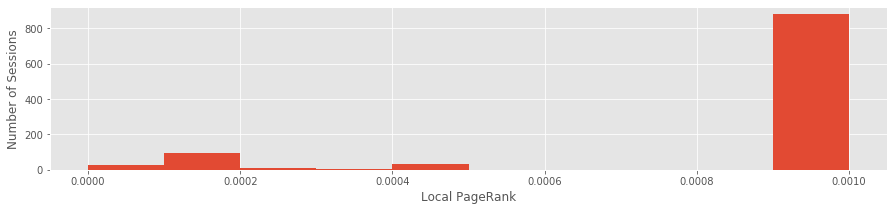

time: 207 ms


In [178]:
d_max = all_session_pr['lpr'].max()
bin_width= 0.0001

all_session_pr['lpr'] \
    .plot(kind='hist', bins=np.arange(0, d_max + bin_width, bin_width))
plt.xlabel('Local PageRank')
plt.ylabel('Number of Sessions')
plt.show()

## Distribution of average number of entities per session over time

In [179]:
entities_per_session_over_time = pd.DataFrame(qlog[['query', 'session_id', 'entities', 'timestamp']])

entities_per_session_over_time['entities'] = \
    entities_per_session_over_time['entities'].map(lambda e: len(e) if e else 0)

entities_per_session_over_time['delta_time'] = entities_per_session_over_time[['session_id', 'timestamp']] \
    .groupby('session_id') \
    .transform(lambda x: x - x.min())

entities_per_session_over_time = entities_per_session_over_time \
    .groupby(['session_id', 'delta_time']) \
    .sum() \
    .reset_index()[['delta_time', 'entities']] \
    .groupby('delta_time') \
    .mean() \
    .rolling(window=30) \
    .mean()

entities_per_session_over_time.index = pd.to_datetime(
    entities_per_session_over_time.index.map(lambda t: int(t.total_seconds())),
    unit='s')

entities_per_session_over_time

,entities
delta_time,
1970-01-01 00:00:00,NaN
1970-01-01 00:00:00,NaN
1970-01-01 00:00:00,NaN
1970-01-01 00:00:00,NaN
...,...
1970-01-01 06:05:56,0.166667
1970-01-01 06:10:47,0.200000
1970-01-01 06:25:27,0.166667
1970-01-01 06:31:58,0.166667


time: 34.4 s


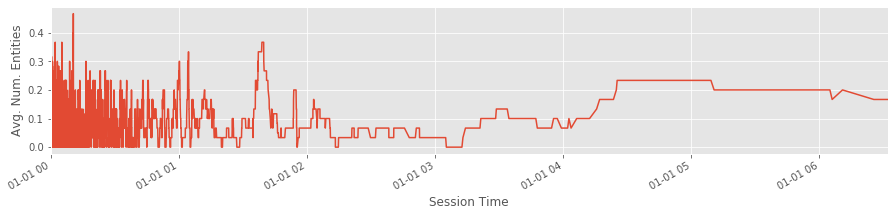

time: 249 ms


In [180]:
entities_per_session_over_time \
    .plot(kind='line', legend=False)
plt.xlabel('Session Time')
plt.ylabel('Avg. Num. Entities')
plt.show()

## Distribution of average entity importance (PageRank) per session over time

In [181]:
@memory.cache
def compute_entity_importance_per_session_over_time():
    entity_importance_per_session_over_time = pd.DataFrame(qlog[['query', 'session_id', 'entities', 'timestamp']])

    def entities_to_pagerank(entities):
        pr_v = []
        for entity in entities:
            try:
                pr_v.append(g.vs.find(label=entity)['pr'])
            except ValueError:
                pr_v.append(0)
        return pr_v

    entity_importance_per_session_over_time['avg_pr'] = \
        entity_importance_per_session_over_time['entities'] \
            .map(lambda e: np.mean(entities_to_pagerank(e)) if e else 0)

    entity_importance_per_session_over_time['delta_time'] = \
        entity_importance_per_session_over_time[['session_id', 'timestamp']] \
            .groupby('session_id') \
            .transform(lambda x: x - x.min())

    entity_importance_per_session_over_time = entity_importance_per_session_over_time \
        .groupby(['session_id', 'delta_time']) \
        .sum() \
        .reset_index()[['delta_time', 'avg_pr']] \
        .groupby('delta_time') \
        .mean() \
        .rolling(window=30) \
        .mean()

    entity_importance_per_session_over_time.index = pd.to_datetime(
        entity_importance_per_session_over_time.index.map(lambda t: int(t.total_seconds())),
        unit='s')

    return entity_importance_per_session_over_time

entity_importance_per_session_over_time = compute_entity_importance_per_session_over_time()
entity_importance_per_session_over_time

,avg_pr
delta_time,
1970-01-01 00:00:00,NaN
1970-01-01 00:00:01,NaN
1970-01-01 00:00:02,NaN
1970-01-01 00:00:03,NaN
...,...
1970-01-01 02:37:32,0.000003
1970-01-01 02:39:20,0.000003
1970-01-01 03:04:40,0.000003
1970-01-01 03:25:45,0.000003


time: 47.7 ms


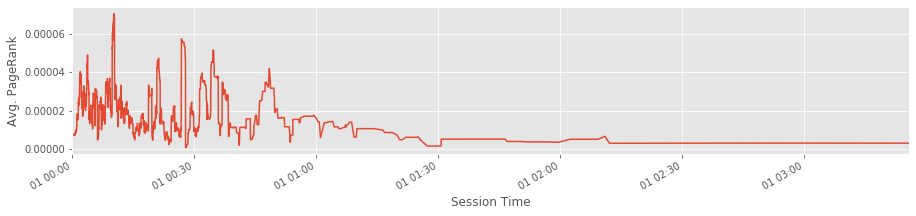

time: 199 ms


In [182]:
entity_importance_per_session_over_time \
    .plot(kind='line', legend=False)
plt.xlabel('Session Time')
plt.ylabel('Avg. PageRank')
plt.show()

# Entity-term-level analysis

- Distribution of entities per query length (in number of terms)
- Distribution of terms per entity

## Distribution of entities per query length (in number of terms)

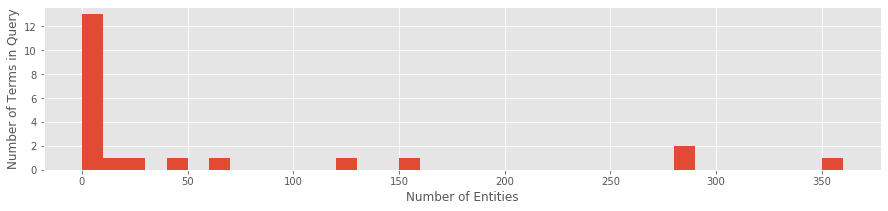

time: 374 ms


In [183]:
entities_per_query_num_terms = qlog[['num_terms', 'entities']] \
    .groupby('num_terms') \
    .apply(lambda df: len(set(flatten(df['entities'])))) \
    .sort_values(ascending=False)

bin_width = 10

entities_per_query_num_terms \
    .plot(kind='hist', bins=range(0, entities_per_query_num_terms.max() + bin_width, bin_width))
plt.xlabel("Number of Entities")
plt.ylabel("Number of Terms in Query")
plt.show()

## Distribution of terms per entity (top 25)

In [184]:
unique_entities = np.unique([
    entity for entities in qlog['entities'] if entities
    for entity in entities])

terms_per_entity = pd.DataFrame({'entity': unique_entities})
terms_per_entity['entity_num_terms'] = terms_per_entity['entity'].map(lambda entity: len(entity.split(' ')))

terms_per_entity = terms_per_entity \
    .sort_values(by='entity_num_terms', ascending=False)

terms_per_entity

,entity,entity_num_terms
149,faculdade de engenharia da universidade do porto,7
160,fernando teixeira dos santos,4
229,josé alberto costa,3
164,filipe da silva,3
...,...,...
210,informatica,1
209,inform,1
208,infor,1
271,laginha,1


time: 27.5 ms


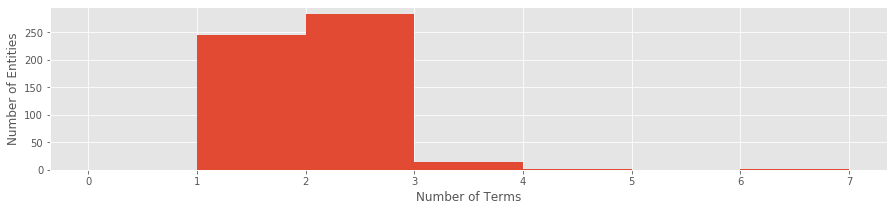

time: 237 ms


In [185]:
d_max = terms_per_entity['entity_num_terms'].max()
bin_width = 1

terms_per_entity['entity_num_terms'] \
    .plot(kind='hist', bins=range(0, d_max + bin_width, bin_width))
plt.xlabel('Number of Terms')
plt.ylabel('Number of Entities')
plt.show()

# Entity-entity-level analysis

- Entity co-occurrence graph
- Entity co-occurrence graph vs Simple Wikipedia link graph
  - Indegree correlation
  - PageRank correlation
  - Closeness centrality correlation
  - Betweenness centrality correlation

## Entity co-occurrence graph

### Building and characterizing the entity co-occurrence graph

In [186]:
@memory.cache
def build_entity_cooccurrence_graph():
    g = igraph.Graph()
    
    graph = {}
    
    for t in qlog.itertuples():
        if t.entities is None:
            continue
        
        for source in t.entities:
            if not source in graph:
                graph[source] = {}
            
            for target in t.entities:
                if source != target:
                    if not target in graph[source]:
                        graph[source][target] = 1
                    else:
                        graph[source][target] += 1

    g.add_vertices(iter(graph.keys()))
    edges = [(source, target) for source in graph.keys() for target in graph[source].keys()]
    edges = [edge for edge in edges if edge[0] > edge[1]]
    g.add_edges(edges)
    
    return g

cg = build_entity_cooccurrence_graph()

time: 48.8 ms


In [203]:
cg_stats = compute_stats(cg); cg_stats

vertices          707.000000
edges             257.000000
avg_clust_coef      0.403587
density             0.001030
num_cc            501.000000
avg_cc_size         1.411178
stdev_cc_size       2.554514
dtype: float64

time: 9.08 ms


In [188]:
cg.vs['in'] = cg.indegree()
cg.vs['pr'] = cg.pagerank()
cg.vs['cc'] = cg.closeness()
cg.vs['bc'] = cg.betweenness()
cg.vs['label'] = cg.vs['name']

time: 4.74 ms


### Visualizing the entity co-occurrence graph

Below we plot the components with more than three nodes.

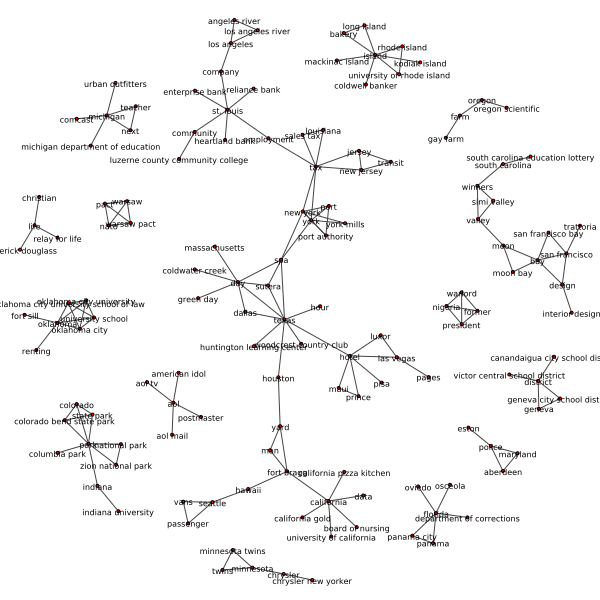

time: 163 ms


In [197]:
cg_components = [cg_component for cg_component in cg.components() if len(cg_component) > 3]
igraph.plot(cg.subgraph(flatten(cg_components)), vertex_size=3, vertex_label_size=8)

## Entity co-occurrence graph vs Simple Wikipedia link graph

First, we prepare the Simple Wikipedia subgraph containing only the entity nodes in the co-occurrence graph.

In [190]:
sg = g.subgraph(g.vs.select(label_in=cg.vs['label']))

time: 7.85 s


In [191]:
sg.vs['in'] = sg.indegree()
sg.vs['pr'] = sg.pagerank()
sg.vs['cc'] = sg.closeness()
sg.vs['bc'] = sg.betweenness()

time: 15.5 ms


In [204]:
sg_stats = compute_stats(sg); sg_stats

vertices           358.000000
edges             1552.000000
avg_clust_coef       0.700346
density              0.012143
num_cc             241.000000
avg_cc_size          1.485477
stdev_cc_size        6.629558
dtype: float64

time: 8.68 ms


### Indegree correlation

In [193]:
sg_in = pd.DataFrame({ 'entity': sg.vs['label'], 'in_sg': sg.vs['in'] })
cg_in = pd.DataFrame({ 'entity': cg.vs['label'], 'in_cg': cg.vs['in'] })
df_in = sg_in.merge(cg_in)
df_in['in_sg'].corr(df_in['in_cg'])

0.2444441834565536

time: 21.4 ms


### PageRank correlation

In [194]:
sg_pr = pd.DataFrame({ 'entity': sg.vs['label'], 'pr_sg': sg.vs['pr'] })
cg_pr = pd.DataFrame({ 'entity': cg.vs['label'], 'pr_cg': cg.vs['pr'] })
df_pr = sg_pr.merge(cg_pr)
df_pr['pr_sg'].corr(df_pr['pr_cg'])

0.20622073644796002

time: 17.7 ms


### Closeness centrality correlation

In [195]:
sg_cc = pd.DataFrame({ 'entity': sg.vs['label'], 'cc_sg': sg.vs['cc'] })
cg_cc = pd.DataFrame({ 'entity': cg.vs['label'], 'cc_cg': cg.vs['cc'] })
df_cc = sg_cc.merge(cg_cc)
df_cc['cc_sg'].corr(df_cc['cc_cg'])

0.1067526533029727

time: 16.8 ms


### Betweenness centrality correlation x

In [196]:
sg_bc = pd.DataFrame({ 'entity': sg.vs['label'], 'bc_sg': sg.vs['bc'] })
cg_bc = pd.DataFrame({ 'entity': cg.vs['label'], 'bc_cg': cg.vs['bc'] })
df_bc = sg_bc.merge(cg_bc)
df_bc['bc_sg'].corr(df_bc['bc_cg'])

0.07713627173530872

time: 18.9 ms
